In [2]:
#prepare package and some self-defined functions

#code reference: https://github.com/sophwats/XGBoost-lambdaMART/blob/master/LambdaMART%20from%20XGBoost.ipynb



# %matplotlib inline
import pickle
import xgboost as xgb
import graphviz
import matplotlib
import math
import pdb
import xlrd

def read_qid_from_LibSV4(file_loc):
    """
    Read the duplicative qid from ibSV4_qid.txt
    """
    with open(file_loc,'r',encoding='UTF-8') as rf:
        lines = rf.readlines()
    qid_lst_LibSV = list()
    for line in lines:
        qid_lst_LibSV.append(line.split(' ')[1].split(':')[1])
    return qid_lst_LibSV

def get_group_cnts(qid_lst_LibSV, qid_lst):
    """
    get the count of items in each qid group, as shown in each LibSV4_qid.txt file
    Checked
    """
    group_cnts = list()
    for qid in qid_lst:
        group_cnts.append(qid_lst_LibSV.count(qid))
    return group_cnts


def calc_qid_prdc_originIDX(preds_lst,group_cnts):
    start_cnt=0
    end_cnt=0
    j=1
    qid_prdc_originIDX_dict=dict()
    for count_item in group_cnts:
        start_cnt=end_cnt
        end_cnt=end_cnt+count_item
        score_lst=list()
        for i in range(start_cnt,end_cnt):
            score_lst.append(preds_lst[i])
        qid_prdc_originIDX_dict[str(j)]=score_lst.index(max(score_lst))
        j=j+1
    
    return qid_prdc_originIDX_dict


def calc_ownername_prdc_origin_dict(qid_prdc_originIDX_dict,user_country_feat_dict_test_str):
    """
    read from json, to get user's real origin
    """
    
    with open(user_country_feat_dict_test_str,'r',encoding="utf-8-sig") as js_f:
            user_loc_features = json.load(js_f)
#     with open('H:/Python/central project 3/data/5-fold/Fold5/user_country_feat_dict_test.json','r',encoding="utf-8-sig") as js_f:
    predict_origin_dict=dict()
    i=1
    for user_name in user_loc_features.keys():
        str_i=str(i)
        origin_loc=list(user_loc_features[user_name])[qid_prdc_originIDX_dict[str_i]]
        predict_origin_dict[user_name]=origin_loc
        i=i+1
    return predict_origin_dict

[15:18:31] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[15:18:31] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt


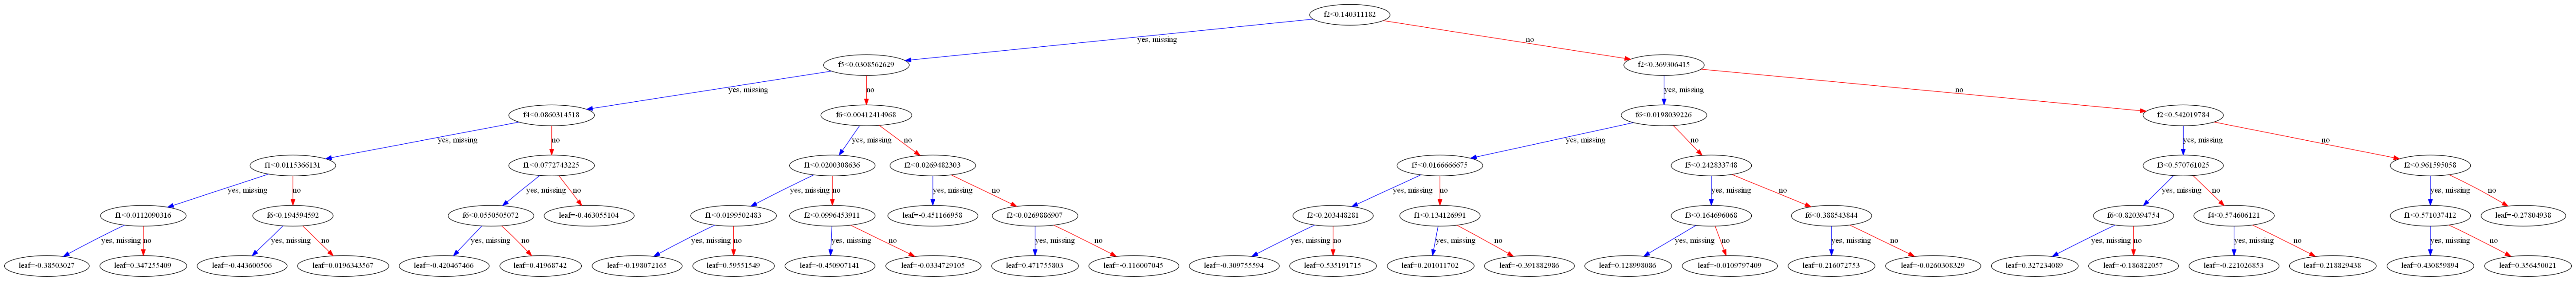

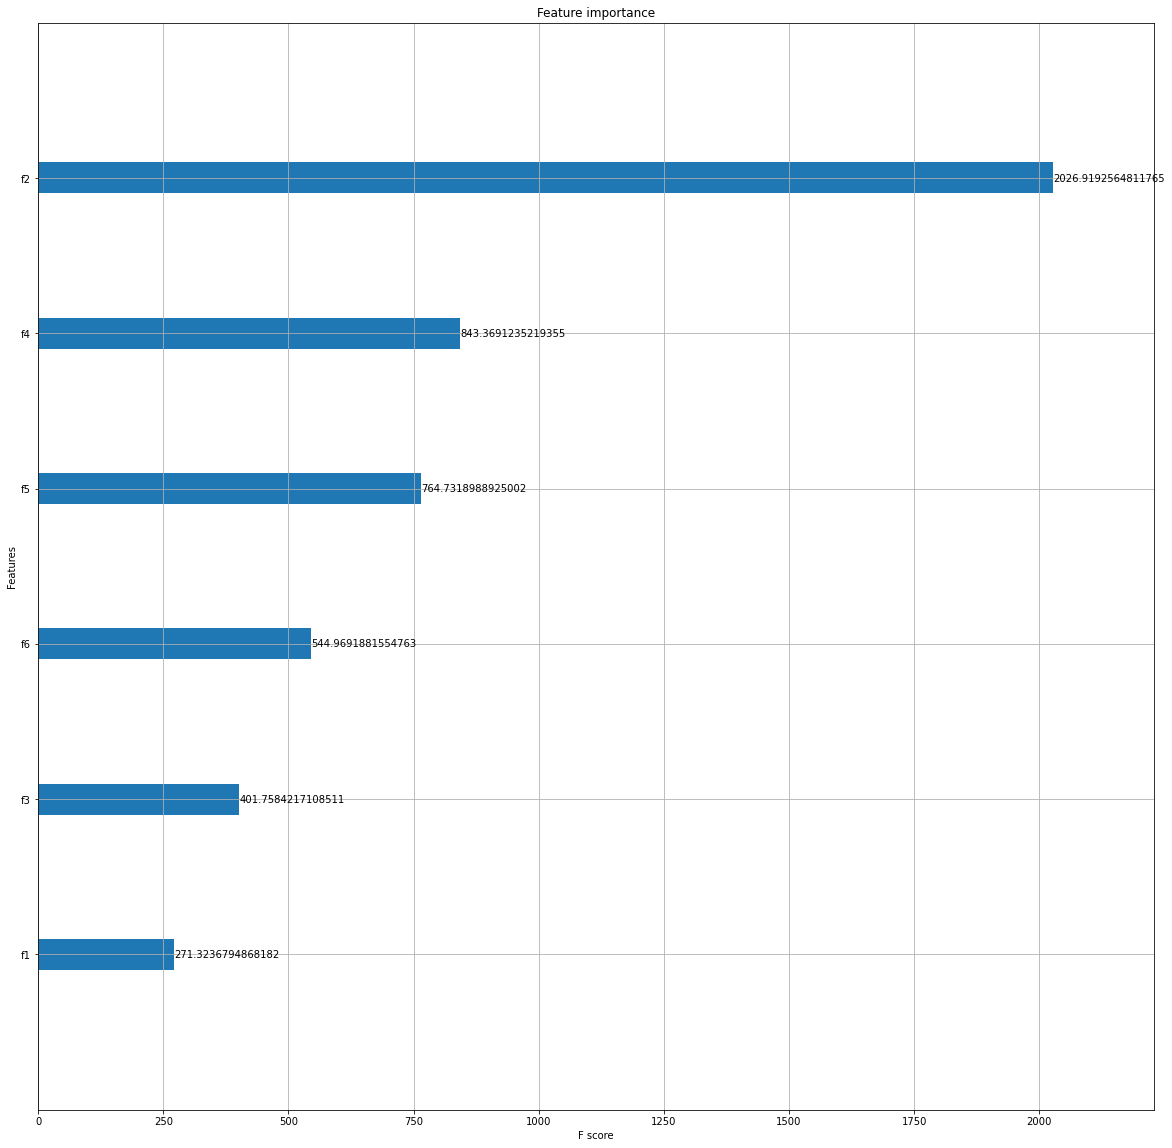

In [3]:
# plot model tree and importance 
param = {'max_depth':5, 'eta':0.8, 'silent':0, 'objective':'rank:pairwise', 'num_round':100}
folder='H:/Python/central project 3/data/5-fold/Fold5'
my_training_data = xgb.DMatrix(folder + '/train.txt')
my_testing_data = xgb.DMatrix(folder + '/test.txt')

#train model
model = xgb.train(param, my_training_data)

#plot
xgb.plot_tree(model, num_trees=3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)



ax = xgb.plot_importance(model,importance_type='cover') # Remember to try different importance_type here: weight, gain, cover. 
                                                                    # The result show that the f2 is always the most important features
fig = ax.figure
fig.set_size_inches(20, 20)

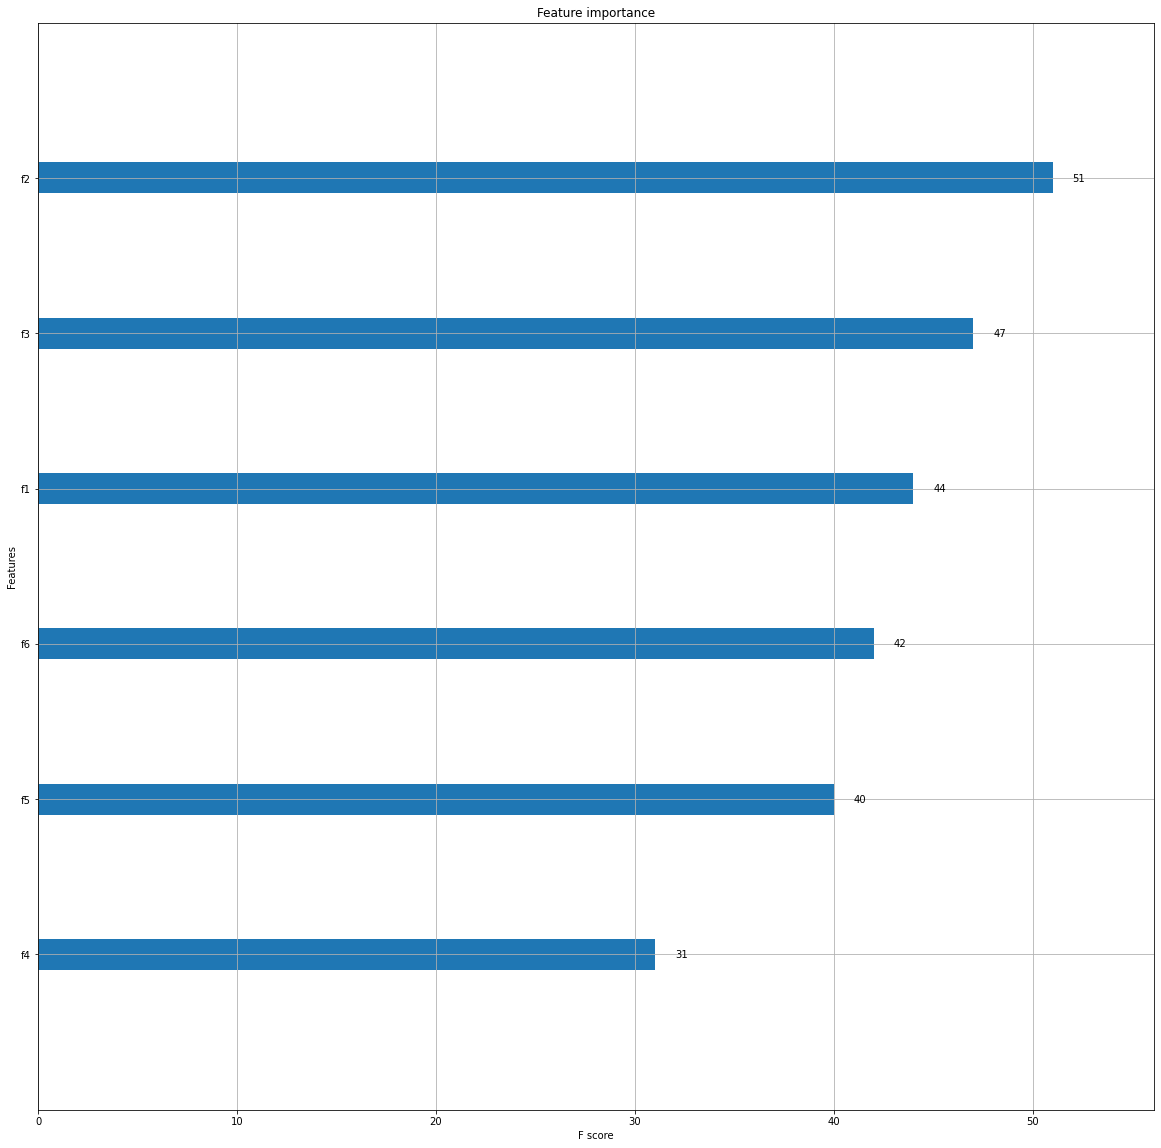

In [4]:
ax = xgb.plot_importance(model,importance_type='weight') # Remember to try different importance_type here: weight, gain, cover. 
                                                                    # The result show that the f2 is always the most important features
fig = ax.figure
fig.set_size_inches(20, 20)

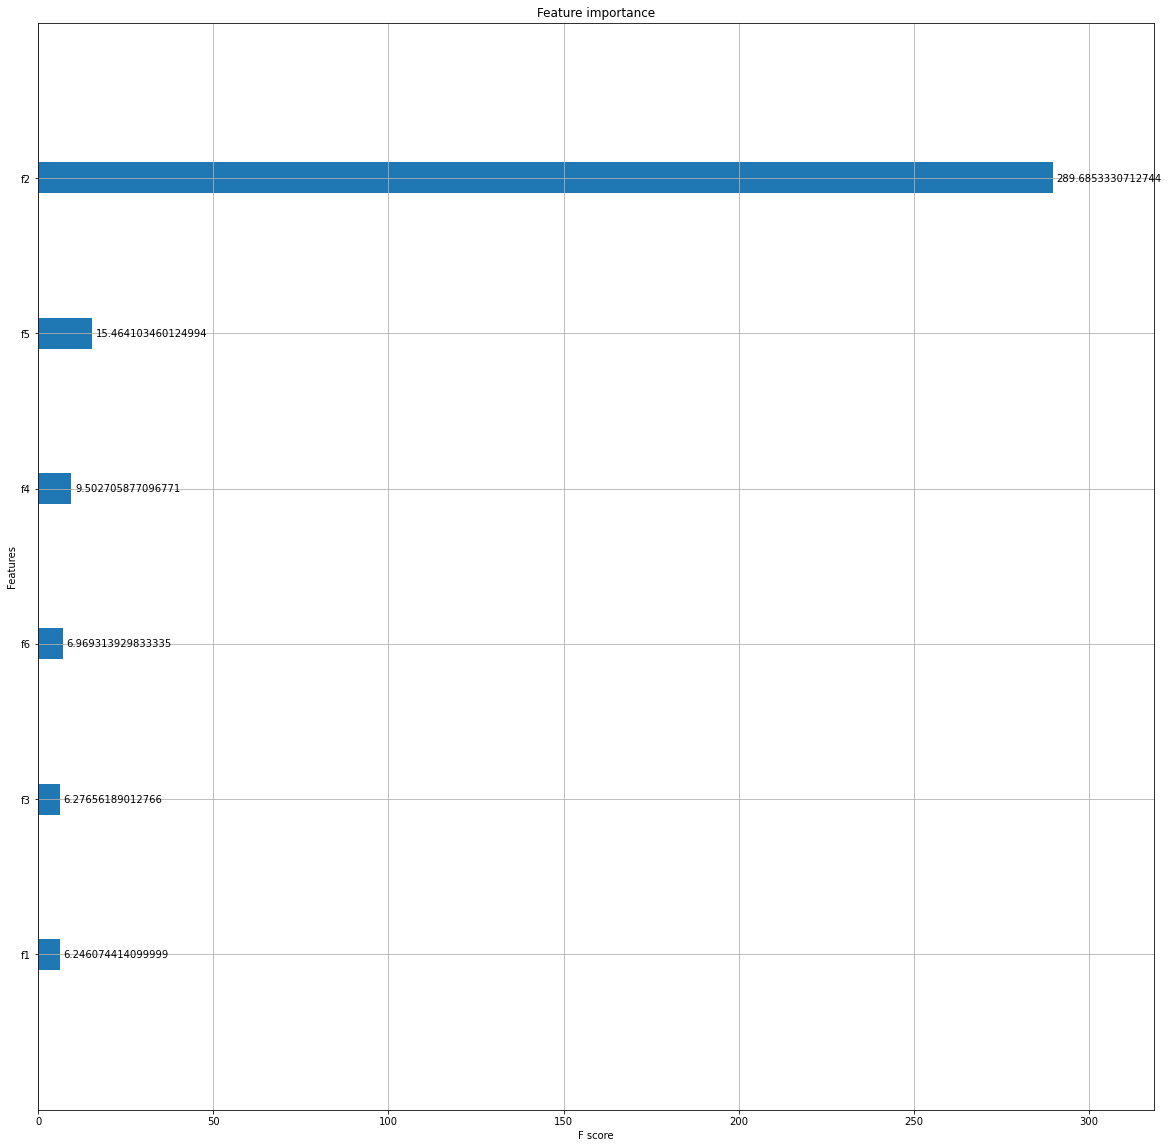

In [5]:
ax = xgb.plot_importance(model,importance_type='gain') # Remember to try different importance_type here: weight, gain, cover. 
                                                                    # The result show that the f2 is always the most important features
fig = ax.figure
fig.set_size_inches(20, 20)

In [9]:


param = {'max_depth':5, 'eta':0.8, 'silent':0, 'objective':'rank:pairwise', 'num_round':100}
# param = {'max_depth':13, 'eta':0.88, 'silent':0, 'objective':'rank:pairwise', 'num_round':100}

sum_precision_1 = 0
sum_precision_2 = 0
sum_precision_4 = 0
sum_precision_5 = 0
sum_precision_6 = 0
my_sum_precision = 0

sum_recall_1 = 0
sum_recall_2 = 0
sum_recall_4 = 0
sum_recall_5 = 0
sum_recall_6 = 0
my_sum_recall = 0



sum_loc_torst_accuracy_1 = 0
sum_loc_torst_accuracy_2 = 0
sum_loc_torst_accuracy_4 = 0
sum_loc_torst_accuracy_5 = 0
sum_loc_torst_accuracy_6 = 0
my_sum_loc_torst_accuracy = 0


sum_accuracy_1 = 0
sum_accuracy_2 = 0
sum_accuracy_4 = 0
sum_accuracy_5 = 0
sum_accuracy_6 = 0
my_sum_accuracy = 0


sum_specificity_1 = 0
sum_specificity_2 = 0
sum_specificity_4 = 0
sum_specificity_5 = 0
sum_specificity_6 = 0
my_sum_specificity = 0


for i in range(1,6):
                # read data

    folder='H:/Python/central project 3/central project 3_experiment_data/5-fold/Fold'+str(i)
    my_training_data = xgb.DMatrix(folder + '/train.txt')
    my_testing_data = xgb.DMatrix(folder + '/test.txt')

    #train model
    model = xgb.train(param, my_training_data)

                #predict test data
    preds = model.predict(my_testing_data)

                # get user predict origin
    qid_lst_LibSV = read_qid_from_LibSV4(folder + '/test.txt')
    qid_lst = list(dict.fromkeys(qid_lst_LibSV))

    group_cnts = get_group_cnts(qid_lst_LibSV, qid_lst)
    qid_prdc_originIDX_dict = calc_qid_prdc_originIDX(preds,group_cnts)
    predict_origin_dict = calc_ownername_prdc_origin_dict(qid_prdc_originIDX_dict,folder +'/user_country_feat_dict_test.json')



                #Evaluate results

    Excel_data = xlrd.open_workbook('H:/Python/central project 3/central project 3_experiment_data/insn1_user_info_reorganised.xlsx') # read orgin of ground-truth and predicted by baseline methods
    Table = Excel_data.sheets()[0]





    real_hk_local_cnt = 0
    retrieved_hk_local_cnt_1 = 0
    retrieved_hk_local_cnt_2 = 0
    retrieved_hk_local_cnt_4 = 0
    retrieved_hk_local_cnt_5 = 0
    retrieved_hk_local_cnt_6 = 0
    my_retrieved_hk_local_cnt = 0


    true_positive_user_cnt_1 = 0
    true_positive_user_cnt_2 = 0
    true_positive_user_cnt_4 = 0
    true_positive_user_cnt_5 = 0
    true_positive_user_cnt_6 = 0
    my_true_positive_user_cnt = 0


    loc_torst_correct_cnt_1 = 0 # to calculate the accuracy of identfying local and tourists
    loc_torst_correct_cnt_2 = 0
    loc_torst_correct_cnt_4 = 0
    loc_torst_correct_cnt_5 = 0
    loc_torst_correct_cnt_6 = 0
    my_loc_torst_correct_cnt = 0

    
    
    correct_user_cnt_1 = 0  # to calculate the accuracy of home detection
    correct_user_cnt_2 = 0
    correct_user_cnt_4 = 0
    correct_user_cnt_5 = 0
    correct_user_cnt_6 = 0
    my_correct_user_cnt = 0
    
    
    test_user_cnt = 0
    for i in range(1,len(Table._cell_values)):
        ownername = str(Table._cell_values[i][0])
        if ownername in predict_origin_dict:
            test_user_cnt = test_user_cnt + 1

            real_origin = Table._cell_values[i][2] # the real origin of a user
            origin_1 = Table._cell_values[i][4] # the origin detected by method 1 MP
            origin_2 = Table._cell_values[i][5] # the origin detected by method 2 MAD
            origin_4 = Table._cell_values[i][6] # the origin detected by method 4 MP-19-7
            origin_5 = Table._cell_values[i][7] # the origin detected by method 5 MAD-19-7
            origin_6 = Table._cell_values[i][8] # the origin detected by method 6 MFＶ
            my_predict_origin = predict_origin_dict[ownername].replace(" ","")

            
            
            if my_predict_origin == "England":
                my_predict_origin = "UK"

            if origin_1 in real_origin:
                correct_user_cnt_1 = correct_user_cnt_1 + 1
            if origin_2 in real_origin:
                correct_user_cnt_2 = correct_user_cnt_2 + 1
            if origin_4 in real_origin:
                correct_user_cnt_4 = correct_user_cnt_4 + 1
            if origin_5 in real_origin:
                correct_user_cnt_5 = correct_user_cnt_5 + 1
            if origin_6 in real_origin:
                correct_user_cnt_6 = correct_user_cnt_6 + 1
            if my_predict_origin in real_origin:
                my_correct_user_cnt = my_correct_user_cnt + 1
            
            
            
            
            if (origin_1 == '香港' and '香港' in real_origin) or (origin_1 != '香港' and '香港' not in real_origin):
                loc_torst_correct_cnt_1 = loc_torst_correct_cnt_1 + 1
            if (origin_2 == '香港' and '香港' in real_origin) or (origin_2 != '香港' and '香港' not in real_origin):
                loc_torst_correct_cnt_2 = loc_torst_correct_cnt_2 + 1 
            if (origin_4 == '香港' and '香港' in real_origin) or (origin_4 != '香港' and '香港' not in real_origin):
                loc_torst_correct_cnt_4 = loc_torst_correct_cnt_4 + 1
            if (origin_5 == '香港' and '香港' in real_origin) or (origin_5 != '香港' and '香港' not in real_origin):
                loc_torst_correct_cnt_5 = loc_torst_correct_cnt_5 + 1 
            if (origin_6 == '香港' and '香港' in real_origin) or (origin_6 != '香港' and '香港' not in real_origin):
                loc_torst_correct_cnt_6 = loc_torst_correct_cnt_6 + 1 
            if (my_predict_origin == '香港' and '香港' in real_origin) or (my_predict_origin != '香港' and '香港' not in real_origin):
                my_loc_torst_correct_cnt = my_loc_torst_correct_cnt + 1             
            
            
            if origin_1 == '香港':
                retrieved_hk_local_cnt_1 = retrieved_hk_local_cnt_1 + 1
            if origin_2 == '香港':
                retrieved_hk_local_cnt_2 = retrieved_hk_local_cnt_2 + 1
            if origin_4 == '香港':
                retrieved_hk_local_cnt_4 = retrieved_hk_local_cnt_4 + 1
            if origin_5 == '香港':
                retrieved_hk_local_cnt_5 = retrieved_hk_local_cnt_5 + 1
            if origin_6 == '香港':
                retrieved_hk_local_cnt_6 = retrieved_hk_local_cnt_6 + 1
            if my_predict_origin == '香港':
                my_retrieved_hk_local_cnt = my_retrieved_hk_local_cnt + 1



            if '香港' in real_origin :
                real_hk_local_cnt = real_hk_local_cnt + 1
                if origin_1 == '香港':
                    true_positive_user_cnt_1 = true_positive_user_cnt_1 + 1
                if origin_2 == '香港':
                    true_positive_user_cnt_2 = true_positive_user_cnt_2 + 1
                if origin_4 == '香港':
                    true_positive_user_cnt_4 = true_positive_user_cnt_4 + 1
                if origin_5 == '香港':
                    true_positive_user_cnt_5 = true_positive_user_cnt_5 + 1
                if origin_6 == '香港':
                    true_positive_user_cnt_6 = true_positive_user_cnt_6 + 1
                if my_predict_origin == '香港':
                    my_true_positive_user_cnt = my_true_positive_user_cnt + 1


    # the accuracy in terms of origin detection
    accuracy_1 = correct_user_cnt_1/test_user_cnt
    accuracy_2 = correct_user_cnt_2/test_user_cnt
    accuracy_4 = correct_user_cnt_4/test_user_cnt
    accuracy_5 = correct_user_cnt_5/test_user_cnt
    accuracy_6 = correct_user_cnt_6/test_user_cnt
    my_accuracy = my_correct_user_cnt/test_user_cnt


    
    
    
    # the precision in terms of origin detection
    precision_1 = true_positive_user_cnt_1/retrieved_hk_local_cnt_1
    precision_2 = true_positive_user_cnt_2/retrieved_hk_local_cnt_2
    precision_4 = true_positive_user_cnt_4/retrieved_hk_local_cnt_4
    precision_5 = true_positive_user_cnt_5/retrieved_hk_local_cnt_5
    precision_6 = true_positive_user_cnt_6/retrieved_hk_local_cnt_6
    my_precision = my_true_positive_user_cnt/my_retrieved_hk_local_cnt


    
    # the recall in terms of origin detection
    recall_1 = true_positive_user_cnt_1/real_hk_local_cnt
    recall_2 = true_positive_user_cnt_2/real_hk_local_cnt
    recall_4 = true_positive_user_cnt_4/real_hk_local_cnt
    recall_5 = true_positive_user_cnt_5/real_hk_local_cnt
    recall_6 = true_positive_user_cnt_6/real_hk_local_cnt
    my_recall = my_true_positive_user_cnt/real_hk_local_cnt

    
    # the specificity in terms of origin detection
    real_torst_cnt = test_user_cnt - real_hk_local_cnt
    
    true_negative_user_cnt_1 = loc_torst_correct_cnt_1 - true_positive_user_cnt_1
    true_negative_user_cnt_2 = loc_torst_correct_cnt_2 - true_positive_user_cnt_2
    true_negative_user_cnt_4 = loc_torst_correct_cnt_4 - true_positive_user_cnt_4
    true_negative_user_cnt_5 = loc_torst_correct_cnt_5 - true_positive_user_cnt_5
    true_negative_user_cnt_6 = loc_torst_correct_cnt_6 - true_positive_user_cnt_6
    my_true_negative_user_cnt = my_loc_torst_correct_cnt - my_true_positive_user_cnt
    
    specificity_1 = true_negative_user_cnt_1/real_torst_cnt
    specificity_2 = true_negative_user_cnt_2/real_torst_cnt
    specificity_4 = true_negative_user_cnt_4/real_torst_cnt
    specificity_5 = true_negative_user_cnt_5/real_torst_cnt
    specificity_6 = true_negative_user_cnt_6/real_torst_cnt
    my_specificity = my_true_negative_user_cnt/real_torst_cnt

    

    # the accuracy in terms of origin detection
#     pdb.set_trace()
    loc_torst_accuracy_1 = loc_torst_correct_cnt_1/test_user_cnt
    loc_torst_accuracy_2 = loc_torst_correct_cnt_2/test_user_cnt
    loc_torst_accuracy_4 = loc_torst_correct_cnt_4/test_user_cnt
    loc_torst_accuracy_5 = loc_torst_correct_cnt_5/test_user_cnt
    loc_torst_accuracy_6 = loc_torst_correct_cnt_6/test_user_cnt
    my_loc_torst_accuracy = my_loc_torst_correct_cnt/test_user_cnt

    

#     accuracy_1 = correct_user_cnt_1/test_user_cnt
#     accuracy_2 = correct_user_cnt_2/test_user_cnt
#     accuracy_4 = correct_user_cnt_4/test_user_cnt
#     accuracy_5 = correct_user_cnt_5/test_user_cnt
#     accuracy_6 = correct_user_cnt_6/test_user_cnt
#     my_accuracy = my_correct_user_cnt/test_user_cnt


    sum_accuracy_1 = sum_accuracy_1 + accuracy_1
    sum_accuracy_2 = sum_accuracy_2 + accuracy_2
    sum_accuracy_4 = sum_accuracy_4 + accuracy_4
    sum_accuracy_5 = sum_accuracy_5 + accuracy_5
    sum_accuracy_6 = sum_accuracy_6 + accuracy_6
    my_sum_accuracy =  my_sum_accuracy + my_accuracy  

    
    sum_precision_1 = sum_precision_1 + precision_1
    sum_precision_2 = sum_precision_2 + precision_2
    sum_precision_4 = sum_precision_4 + precision_4
    sum_precision_5 = sum_precision_5 + precision_5
    sum_precision_6 = sum_precision_6 + precision_6
    my_sum_precision =  my_sum_precision + my_precision

    
    sum_recall_1 = sum_recall_1 + recall_1
    sum_recall_2 = sum_recall_2 + recall_2
    sum_recall_4 = sum_recall_4 + recall_4
    sum_recall_5 = sum_recall_5 + recall_5
    sum_recall_6 = sum_recall_6 + recall_6
    my_sum_recall =  my_sum_recall + my_recall

    
    sum_specificity_1 = sum_specificity_1 + specificity_1
    sum_specificity_2 = sum_specificity_2 + specificity_2
    sum_specificity_4 = sum_specificity_4 + specificity_4
    sum_specificity_5 = sum_specificity_5 + specificity_5
    sum_specificity_6 = sum_specificity_6 + specificity_6
    my_sum_specificity = my_sum_specificity + my_specificity
    
    
    sum_loc_torst_accuracy_1 = sum_loc_torst_accuracy_1 + loc_torst_accuracy_1
    sum_loc_torst_accuracy_2 = sum_loc_torst_accuracy_2 + loc_torst_accuracy_2
    sum_loc_torst_accuracy_4 = sum_loc_torst_accuracy_4 + loc_torst_accuracy_4
    sum_loc_torst_accuracy_5 = sum_loc_torst_accuracy_5 + loc_torst_accuracy_5
    sum_loc_torst_accuracy_6 = sum_loc_torst_accuracy_6 + loc_torst_accuracy_6
    my_sum_loc_torst_accuracy = my_sum_loc_torst_accuracy + my_loc_torst_accuracy

    
    #             print("accuracy_1:" + str(accuracy_1))
    #             print("accuracy_2:" + str(accuracy_2))
    #             print("accuracy_4:" + str(accuracy_4))
    #             print("accuracy_5:" + str(accuracy_5))
    #             print("accuracy_6:" + str(accuracy_6))
    #             print("my_accuracy:" + str(my_accuracy))




##########################The average performance of 5 folds###########################
avg_accuracy_1 = sum_accuracy_1/5
avg_accuracy_2 = sum_accuracy_2/5
avg_accuracy_4 = sum_accuracy_4/5
avg_accuracy_5 = sum_accuracy_5/5
avg_accuracy_6 = sum_accuracy_6/5
avg_my_accuracy = my_sum_accuracy/5
    
    

avg_precision_1 = sum_precision_1/5
avg_precision_2 = sum_precision_2/5
avg_precision_4 = sum_precision_4/5
avg_precision_5 = sum_precision_5/5
avg_precision_6 = sum_precision_6/5
avg_my_precision = my_sum_precision/5


avg_recall_1 = sum_recall_1/5
avg_recall_2 = sum_recall_2/5
avg_recall_4 = sum_recall_4/5
avg_recall_5 = sum_recall_5/5
avg_recall_6 = sum_recall_6/5
avg_my_recall = my_sum_recall/5



avg_specificity_1 = sum_specificity_1/5
avg_specificity_2 = sum_specificity_2/5
avg_specificity_4 = sum_specificity_4/5
avg_specificity_5 = sum_specificity_5/5
avg_specificity_6 = sum_specificity_6/5
avg_my_specificity = my_sum_specificity/5


avg_loc_torst_accuracy_1 = sum_loc_torst_accuracy_1/5
avg_loc_torst_accuracy_2 = sum_loc_torst_accuracy_2/5
avg_loc_torst_accuracy_4 = sum_loc_torst_accuracy_4/5
avg_loc_torst_accuracy_5 = sum_loc_torst_accuracy_5/5
avg_loc_torst_accuracy_6 = sum_loc_torst_accuracy_6/5
avg_my_loc_torst_accuracy = my_sum_loc_torst_accuracy/5
########################################################################

#     if avg_my_precision > avg_precision_1 or avg_my_recall > avg_recall_6:
#         str_para="max_depth:"+str(max_depth_value)+" eta:"+str(eta_value)+ " avg_my_precision:" + str(avg_my_precision)+ " avg_my_recall"+str(avg_my_recall)
#         print(str_para)
#         wf.write(str_para+'\n')

print("---------------------------------------")
print("avg_accuracy_1:" + str(avg_accuracy_1))
print("avg_accuracy_2:" + str(avg_accuracy_2))
print("avg_accuracy_4:" + str(avg_accuracy_4))
print("avg_accuracy_5:" + str(avg_accuracy_5))
print("avg_accuracy_6:" + str(avg_accuracy_6))
print("avg_my_accuracy:" + str(avg_my_accuracy))
print("---------------------------------------")


print("avg_precision_1:" + str(avg_precision_1))
print("avg_precisiony_2:" + str(avg_precision_2))
print("avg_precision_4:" + str(avg_precision_4))
print("avg_precision_5:" + str(avg_precision_5))
print("avg_precision_6:" + str(avg_precision_6))
print("avg_my_precision:" + str(avg_my_precision))
print("---------------------------------------")


print("avg_recall_1:" + str(avg_recall_1))
print("avg_recall_2:" + str(avg_recall_2))
print("avg_recall_4:" + str(avg_recall_4))
print("avg_recall_5:" + str(avg_recall_5))
print("avg_recall_6:" + str(avg_recall_6))
print("avg_my_recall:" + str(avg_my_recall))
print("---------------------------------------")


print("avg_specificity_1:" + str(avg_specificity_1))
print("avg_specificity_2:" + str(avg_specificity_2))
print("avg_specificity_4:" + str(avg_specificity_4))
print("avg_specificity_5:" + str(avg_specificity_5))
print("avg_specificity_6:" + str(avg_specificity_6))
print("my_avg_specificity:" + str(avg_my_specificity))
print("---------------------------------------")


print("avg_loc_torst_accuracy_1:" + str(avg_loc_torst_accuracy_1))
print("avg_loc_torst_accuracy_2:" + str(avg_loc_torst_accuracy_2))
print("avg_loc_torst_accuracy_4:" + str(avg_loc_torst_accuracy_4))
print("avg_loc_torst_accuracy_5:" + str(avg_loc_torst_accuracy_5))
print("avg_loc_torst_accuracy_6:" + str(avg_loc_torst_accuracy_6))
print("my_avg_loc_torst_accuracy:" + str(my_avg_loc_torst_accuracy))



[12:03:02] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/central project 3_experiment_data/5-fold/Fold1/train.txt
[12:03:02] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/central project 3_experiment_data/5-fold/Fold1/test.txt
[12:03:04] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/central project 3_experiment_data/5-fold/Fold2/train.txt
[12:03:04] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/central project 3_experiment_data/5-fold/Fold2/test.txt
[12:03:05] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/central project 3_experiment_data/5-fold/Fold3/train.txt
[12:03:05] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/central project 3_experiment_data/5-fold/Fold3/test.txt
[12:03:06] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/central project 3_experiment_data/5-fold/Fold4/train.txt
[12:03:06] 3

In [11]:
#Performance of identifying local and tourist
with open("home_detection_good_parameters.txt","w") as wf:
    for max_depth_value in range(2,30):
        for eta_step in range(1,50):
            eta_value = eta_step/50


            param = {'max_depth':max_depth_value, 'eta':eta_value, 'silent':0, 'objective':'rank:pairwise', 'num_round':100}

            sum_precision_1 = 0
            sum_precision_2 = 0
            sum_precision_4 = 0
            sum_precision_5 = 0
            sum_precision_6 = 0
            my_sum_precision = 0

            sum_recall_1 = 0
            sum_recall_2 = 0
            sum_recall_4 = 0
            sum_recall_5 = 0
            sum_recall_6 = 0
            my_sum_recall = 0

            for i in range(1,6):
                            # read data

                folder='H:/Python/central project 3/data/5-fold/Fold'+str(i)
                my_training_data = xgb.DMatrix(folder + '/train.txt')
                my_testing_data = xgb.DMatrix(folder + '/test.txt')

                #train model
                model = xgb.train(param, my_training_data)

                            #predict test data
                preds = model.predict(my_testing_data)

                            # get user predict origin
                qid_lst_LibSV = read_qid_from_LibSV4(folder + '/test.txt')
                qid_lst = list(dict.fromkeys(qid_lst_LibSV))

                group_cnts = get_group_cnts(qid_lst_LibSV, qid_lst)
                qid_prdc_originIDX_dict = calc_qid_prdc_originIDX(preds,group_cnts)
                predict_origin_dict = calc_ownername_prdc_origin_dict(qid_prdc_originIDX_dict,folder +'/user_country_feat_dict_test.json')



                            #Evaluate results
                import xlrd

                Excel_data = xlrd.open_workbook('H:/Python/central project 3/data/insn1_user_info_reorganised.xlsx') # read orgin of ground-truth and predicted by baseline methods
                Table = Excel_data.sheets()[0]





                real_hk_local_cnt = 0
                retrieved_hk_local_cnt_1 = 0
                retrieved_hk_local_cnt_2 = 0
                retrieved_hk_local_cnt_4 = 0
                retrieved_hk_local_cnt_5 = 0
                retrieved_hk_local_cnt_6 = 0
                my_retrieved_hk_local_cnt = 0


                correct_user_cnt_1 = 0
                correct_user_cnt_2 = 0
                correct_user_cnt_4 = 0
                correct_user_cnt_5 = 0
                correct_user_cnt_6 = 0
                my_correct_user_cnt = 0


                for i in range(1,len(Table._cell_values)):
                    ownername = str(Table._cell_values[i][0])
                    if ownername in predict_origin_dict:
                        test_user_cnt = test_user_cnt + 1

                        real_origin = Table._cell_values[i][2]
                        origin_1 = Table._cell_values[i][4]
                        origin_2 = Table._cell_values[i][5]
                        origin_4 = Table._cell_values[i][6]
                        origin_5 = Table._cell_values[i][7]
                        origin_6 = Table._cell_values[i][8]
                        my_predict_origin = predict_origin_dict[ownername].replace(" ","")

                        if origin_1 == '香港':
                            retrieved_hk_local_cnt_1 = retrieved_hk_local_cnt_1 + 1
                        if origin_2 == '香港':
                            retrieved_hk_local_cnt_2 = retrieved_hk_local_cnt_2 + 1
                        if origin_4 == '香港':
                            retrieved_hk_local_cnt_4 = retrieved_hk_local_cnt_4 + 1
                        if origin_5 == '香港':
                            retrieved_hk_local_cnt_5 = retrieved_hk_local_cnt_5 + 1
                        if origin_6 == '香港':
                            retrieved_hk_local_cnt_6 = retrieved_hk_local_cnt_6 + 1
                        if my_predict_origin == '香港':
                            my_retrieved_hk_local_cnt = my_retrieved_hk_local_cnt + 1




                        if '香港' in real_origin :
                            real_hk_local_cnt = real_hk_local_cnt + 1
                            if origin_1 == '香港':
                                correct_user_cnt_1 = correct_user_cnt_1 + 1
                            if origin_2 == '香港':
                                correct_user_cnt_2 = correct_user_cnt_2 + 1
                            if origin_4 == '香港':
                                correct_user_cnt_4 = correct_user_cnt_4 + 1
                            if origin_5 == '香港':
                                correct_user_cnt_5 = correct_user_cnt_5 + 1
                            if origin_6 == '香港':
                                correct_user_cnt_6 = correct_user_cnt_6 + 1
                            if my_predict_origin == '香港':
                                my_correct_user_cnt = my_correct_user_cnt + 1




                precision_1 = correct_user_cnt_1/retrieved_hk_local_cnt_1
                precision_2 = correct_user_cnt_2/retrieved_hk_local_cnt_2
                precision_4 = correct_user_cnt_4/retrieved_hk_local_cnt_4
                precision_5 = correct_user_cnt_5/retrieved_hk_local_cnt_5
                precision_6 = correct_user_cnt_6/retrieved_hk_local_cnt_6
                my_precision = my_correct_user_cnt/my_retrieved_hk_local_cnt


                recall_1 = correct_user_cnt_1/real_hk_local_cnt
                recall_2 = correct_user_cnt_2/real_hk_local_cnt
                recall_4 = correct_user_cnt_4/real_hk_local_cnt
                recall_5 = correct_user_cnt_5/real_hk_local_cnt
                recall_6 = correct_user_cnt_6/real_hk_local_cnt
                my_recall = my_correct_user_cnt/real_hk_local_cnt


            #     accuracy_1 = correct_user_cnt_1/test_user_cnt
            #     accuracy_2 = correct_user_cnt_2/test_user_cnt
            #     accuracy_4 = correct_user_cnt_4/test_user_cnt
            #     accuracy_5 = correct_user_cnt_5/test_user_cnt
            #     accuracy_6 = correct_user_cnt_6/test_user_cnt
            #     my_accuracy = my_correct_user_cnt/test_user_cnt


                sum_precision_1 = sum_precision_1 + precision_1
                sum_precision_2 = sum_precision_2 + precision_2
                sum_precision_4 = sum_precision_4 + precision_4
                sum_precision_5 = sum_precision_5 + precision_5
                sum_precision_6 = sum_precision_6 + precision_6
                my_sum_precision =  my_sum_precision + my_precision

                sum_recall_1 = sum_recall_1 + recall_1
                sum_recall_2 = sum_recall_2 + recall_2
                sum_recall_4 = sum_recall_4 + recall_4
                sum_recall_5 = sum_recall_5 + recall_5
                sum_recall_6 = sum_recall_6 + recall_6
                my_sum_recall =  my_sum_recall + my_recall

                #             print("accuracy_1:" + str(accuracy_1))
                #             print("accuracy_2:" + str(accuracy_2))
                #             print("accuracy_4:" + str(accuracy_4))
                #             print("accuracy_5:" + str(accuracy_5))
                #             print("accuracy_6:" + str(accuracy_6))
                #             print("my_accuracy:" + str(my_accuracy))


            avg_precision_1 = sum_precision_1/5
            avg_precision_2 = sum_precision_2/5
            avg_precision_4 = sum_precision_4/5
            avg_precision_5 = sum_precision_5/5
            avg_precision_6 = sum_precision_6/5
            avg_my_precision = my_sum_precision/5


            avg_recall_1 = sum_recall_1/5
            avg_recall_2 = sum_recall_2/5
            avg_recall_4 = sum_recall_4/5
            avg_recall_5 = sum_recall_5/5
            avg_recall_6 = sum_recall_6/5
            avg_my_recall = my_sum_recall/5

            if avg_my_precision > avg_precision_1 or avg_my_recall > avg_recall_6:
                str_para="max_depth:"+str(max_depth_value)+" eta:"+str(eta_value)+ " avg_my_precision:" + str(avg_my_precision)+ " avg_my_recall"+str(avg_my_recall)
                print(str_para)
                wf.write(str_para+'\n')

#             str_para="max_depth:"+str(max_depth_value)+" eta:"+str(eta_value)+ " avg_my_accuracy:" + str(avg_my_accuracy)
#             print(str_para)
#             wf.write(str_para+'\n')
            # print("avg_precision_1:" + str(avg_precision_1))
            # print("avg_precisiony_2:" + str(avg_precision_2))
            # print("avg_precision_4:" + str(avg_precision_4))
            # print("avg_precision_5:" + str(avg_precision_5))
            # print("avg_precision_6:" + str(avg_precision_6))
            # print("avg_my_precision:" + str(avg_my_precision))

            # print("avg_recall_1:" + str(avg_recall_1))
            # print("avg_recall_2:" + str(avg_recall_2))
            # print("avg_recall_4:" + str(avg_recall_4))
            # print("avg_recall_5:" + str(avg_recall_5))
            # print("avg_recall_6:" + str(avg_recall_6))
            # print("avg_my_recall:" + str(avg_my_recall))


[16:17:55] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:17:55] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:17:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:17:57] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:17:58] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:17:58] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:18:00] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:18:00] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:18:01] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:18:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:18:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:18:52] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:18:52] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:18:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:18:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:18:55] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:18:55] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:18:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:19:44] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:19:44] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:19:46] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:19:46] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:19:47] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:19:47] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:19:48] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:19:48] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:19:50] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:20:37] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:20:37] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:20:39] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:20:39] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:20:40] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:20:40] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:20:42] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:20:42] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:20:43] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:21:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:21:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:21:33] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:21:33] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:21:34] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:21:34] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:21:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:21:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:21:37] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:22:25] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:22:25] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:22:26] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:22:26] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:22:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:22:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:22:29] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:22:29] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:22:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:23:17] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:23:17] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:23:19] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:23:19] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:23:20] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:23:20] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:23:22] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:23:22] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:23:23] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:24:11] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:24:11] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:24:12] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:24:13] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:24:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:24:14] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:24:15] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:24:15] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:24:17] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:25:04] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:25:04] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:25:05] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:25:05] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:25:06] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:25:06] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:25:08] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:25:08] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:25:09] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:25:57] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:25:57] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:25:58] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:25:58] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:26:00] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:26:00] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:26:01] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:26:01] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:26:03] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:26:52] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:26:52] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:26:53] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:26:53] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:26:55] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:26:55] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:26:56] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:26:56] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:26:58] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:27:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:27:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:27:46] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:27:46] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:27:47] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:27:47] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:27:49] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:27:49] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:27:50] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:28:37] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:28:37] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:28:38] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:28:38] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:28:40] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:28:40] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:28:41] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:28:41] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:28:43] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:29:30] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:29:30] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:29:31] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:29:31] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:29:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:29:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:29:34] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:29:34] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:29:35] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:30:23] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:30:23] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:30:24] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:30:24] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:30:26] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:30:26] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:30:27] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:30:27] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:30:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:31:17] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:31:17] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:31:19] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:31:19] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:31:20] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:31:20] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:31:22] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:31:22] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:31:23] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:32:11] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:32:11] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:32:13] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:32:13] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:32:14] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:32:14] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:32:16] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:32:16] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:32:17] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:33:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:33:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:33:06] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:33:06] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:33:08] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:33:08] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:33:09] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:33:09] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:33:11] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:33:58] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:33:58] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:34:00] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:34:00] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:34:01] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:34:01] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:34:03] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:34:03] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:34:04] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:34:51] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:34:51] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:34:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:34:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:34:54] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:34:54] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:34:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:34:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:34:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:35:45] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:35:45] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:35:46] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:35:46] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:35:48] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:35:48] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:35:49] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:35:49] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:35:50] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:36:41] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:36:41] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:36:42] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:36:42] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:36:44] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:36:44] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:36:45] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:36:45] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:36:46] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:37:35] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:37:35] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:37:37] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:37:37] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:37:38] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:37:38] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:37:40] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:37:40] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:37:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:38:29] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:38:29] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:38:30] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:38:31] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:38:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:38:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:38:34] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:38:34] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:38:35] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:39:23] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:39:23] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:39:25] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:39:25] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:39:26] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:39:26] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:39:28] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:39:28] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:39:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:40:18] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:40:18] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:40:19] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:40:19] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:40:21] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:40:21] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:40:22] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:40:22] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:40:24] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:41:13] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:41:13] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:41:15] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:41:15] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:41:16] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:41:16] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:41:18] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:41:18] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:41:19] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:42:07] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:42:07] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:42:09] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:42:09] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:42:10] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:42:10] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:42:12] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:42:12] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:42:13] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:43:02] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:43:02] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:43:04] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:43:04] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:43:05] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:43:05] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:43:07] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:43:07] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:43:08] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:43:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:43:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:44:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:44:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:44:01] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:44:01] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:44:03] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:44:03] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:44:04] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:44:53] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:44:53] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:44:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:44:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:44:56] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:44:56] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:44:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:44:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:44:59] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:45:49] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:45:49] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:45:50] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:45:50] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:45:51] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:45:51] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:45:53] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:45:53] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:45:54] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:46:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:46:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:46:44] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:46:44] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:46:46] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:46:46] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:46:47] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:46:47] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:46:49] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:47:38] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:47:38] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:47:39] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:47:39] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:47:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:47:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:47:42] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:47:42] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:47:44] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:48:33] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:48:33] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:48:34] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:48:34] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:48:36] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:48:36] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:48:37] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:48:37] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:48:39] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:49:27] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:49:27] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:49:29] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:49:29] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:49:30] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:49:30] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:49:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:49:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:49:33] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:50:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:50:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:50:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:50:25] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:50:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:50:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:50:28] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:50:28] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:50:30] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:51:19] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:51:19] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:51:20] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:51:20] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:51:22] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:51:22] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:51:23] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:51:23] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:51:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:52:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:52:14] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:52:16] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:52:16] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:52:17] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:52:17] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:52:19] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:52:19] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:52:20] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:53:10] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:53:10] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:53:12] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:53:12] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:53:14] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:53:14] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:53:15] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:53:15] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:53:17] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:54:07] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:54:07] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:54:08] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:54:08] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:54:10] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:54:10] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:54:11] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:54:11] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:54:13] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:55:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:55:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:55:04] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:55:04] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:55:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:55:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:55:07] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:55:07] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:55:08] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[16:55:59] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:55:59] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:56:01] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:56:01] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:56:02] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:56:02] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:56:04] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:56:04] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:56:05] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[16:56:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:56:57] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:56:59] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:56:59] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:57:00] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:57:00] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:57:02] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:57:02] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:57:03] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[16:57:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:57:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:57:55] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:57:55] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:57:56] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:57:56] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:57:58] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:57:58] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:57:59] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[16:58:48] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:58:48] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:58:50] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[16:58:50] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[16:58:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:58:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:58:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:58:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:58:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[16:59:44] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[16:59:44] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[16:59:45] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[16:59:45] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[16:59:47] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[16:59:47] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[16:59:48] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[16:59:48] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[16:59:50] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:00:39] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:00:39] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:00:41] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:00:41] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:00:42] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:00:42] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:00:44] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:00:44] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:00:45] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:01:34] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:01:34] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:01:35] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:01:35] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:01:37] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:01:37] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:01:38] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:01:38] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:01:40] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:02:29] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:02:29] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:02:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:02:30] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:02:32] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:02:32] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:02:33] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:02:33] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:02:35] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:03:24] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:03:24] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:03:25] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:03:25] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:03:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:03:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:03:28] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:03:28] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:03:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:04:19] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:04:19] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:04:21] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:04:21] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:04:22] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:04:22] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:04:24] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:04:24] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:04:25] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:05:17] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:05:17] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:9 eta:0.84 avg_my_precision:0.8714947177567405 avg_my_recall0.6476535051702428
[17:05:18] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:05:18] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:05:20] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:05:20] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:05:21] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:05:21] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:05:23] 1630

[17:06:11] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:06:11] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:06:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:06:12] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:06:14] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:06:14] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:06:15] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:06:15] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:06:17] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:07:06] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:07:06] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:07:08] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:07:08] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:07:09] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:07:09] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:07:11] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:07:11] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:07:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:08:02] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:08:02] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:08:04] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:08:04] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:08:05] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:08:05] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:08:07] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:08:07] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:08:08] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:08:58] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:08:58] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:08:59] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:08:59] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:09:01] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:09:01] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:09:02] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:09:02] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:09:04] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:09:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:09:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:09:55] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:09:55] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:09:56] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:09:56] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:09:58] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:09:58] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:09:59] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:10:49] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:10:49] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:10:51] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:10:51] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:10:52] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:10:52] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:10:54] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:10:54] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:10:55] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:11:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:11:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:11:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:11:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:11:48] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:11:48] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:11:49] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:11:49] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:11:51] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:12:40] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:12:40] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:12:42] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:12:42] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:12:43] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:12:43] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:12:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:12:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:12:46] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:13:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:13:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:13:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:13:38] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:13:39] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:13:39] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:13:41] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:13:41] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:13:42] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:14:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:14:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:14:34] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:14:34] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:14:35] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:14:35] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:14:37] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:14:37] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:14:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:15:28] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:15:28] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:15:30] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:15:30] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:15:31] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:15:31] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:15:33] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:15:33] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:15:34] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:16:25] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:16:25] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:16:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:16:26] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:16:28] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:16:28] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:16:29] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:16:29] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:16:31] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:17:20] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:17:20] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:17:21] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:17:21] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:17:23] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:17:23] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:17:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:17:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:17:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:18:16] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:18:16] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:18:18] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:18:18] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:18:19] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:18:19] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:18:21] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:18:21] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:18:23] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:19:13] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:19:13] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:19:15] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:19:15] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:19:16] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:19:16] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:19:18] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:19:18] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:19:19] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:20:10] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:20:10] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:20:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:20:12] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:20:13] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:20:13] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:20:15] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:20:15] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:20:16] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:21:07] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:21:07] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:21:08] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:21:08] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:21:10] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:21:10] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:21:12] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:21:12] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:21:13] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:22:04] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:22:04] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:22:05] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:22:05] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:22:07] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:22:07] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:22:08] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:22:08] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:22:10] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:23:02] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:23:02] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:23:03] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:23:03] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:23:05] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:23:05] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:23:06] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:23:06] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:23:08] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:23:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:23:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:24:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:24:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:24:02] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:24:02] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:24:03] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:24:03] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:24:05] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:24:56] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:24:56] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:24:58] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:24:58] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:24:59] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:24:59] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:25:01] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:25:01] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:25:02] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:25:53] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:25:53] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:25:55] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:25:55] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:25:56] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:25:56] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:25:58] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:25:58] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:25:59] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:26:51] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:26:51] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:26:53] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:26:53] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:26:54] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:26:54] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:26:56] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:26:56] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:26:57] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:27:51] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:27:51] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:27:52] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:27:52] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:27:54] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:27:54] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:27:55] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:27:55] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:27:57] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:28:50] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:28:50] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:28:52] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:28:52] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:28:54] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:28:54] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:28:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:28:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:28:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:29:53] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:29:53] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:29:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:29:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:29:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:29:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:29:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:29:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:30:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:30:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:30:54] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:30:55] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:30:55] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:30:57] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:30:57] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:30:58] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:30:59] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:31:00] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:31:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:31:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:31:55] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:31:55] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:31:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:31:57] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:31:59] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:31:59] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:32:00] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:32:53] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:32:53] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:32:55] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:32:55] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:32:57] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:32:57] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:32:58] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:32:58] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:33:00] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:33:54] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:33:54] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:33:55] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:33:55] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:33:57] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:33:57] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:33:58] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:33:58] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:34:00] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:34:53] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:34:53] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:34:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:34:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:34:56] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:34:56] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:34:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:34:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:35:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:35:53] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:35:53] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:35:55] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:35:55] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:35:56] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:35:56] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:35:58] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:35:58] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:35:59] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:36:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:36:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:36:54] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:36:54] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:36:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:36:56] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:36:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:36:58] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:36:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:37:52] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:37:52] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:37:53] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:37:53] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:37:55] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:37:55] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:37:57] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:37:57] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:37:59] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:38:52] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:38:52] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:38:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:38:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:38:55] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:38:55] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:38:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:38:57] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:38:58] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:39:52] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:39:52] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:39:53] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:39:53] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:39:55] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:39:55] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:39:56] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:39:56] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:39:58] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:40:50] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:40:50] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:40:52] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:40:52] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:40:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:40:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:40:55] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:40:55] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:40:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:41:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:41:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:41:51] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:41:51] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:41:52] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:41:52] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:41:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:41:54] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:41:55] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:42:47] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:42:47] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:42:49] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:42:49] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:42:51] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:42:51] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:42:52] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:42:52] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:42:54] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:43:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:43:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:43:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:43:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:43:50] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:43:50] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:43:52] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:43:52] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:43:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:44:46] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:44:46] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:44:47] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:44:47] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:44:49] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:44:49] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:44:51] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:44:51] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:44:52] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:45:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:45:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:45:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:45:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:45:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:45:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:45:50] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:45:50] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:45:52] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:46:46] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:46:46] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:46:48] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:46:48] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:46:49] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:46:49] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:46:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:46:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:46:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:47:45] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:47:45] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:47:47] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:47:47] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:47:48] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:47:48] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:47:50] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:47:50] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:47:52] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:48:44] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:48:44] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:48:45] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:48:45] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:48:47] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:48:47] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:48:48] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:48:48] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:48:50] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:49:41] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:49:41] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:49:43] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:49:43] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:49:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:49:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:49:46] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:49:46] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:49:48] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:50:39] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:50:39] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:50:40] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:50:40] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:50:42] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:50:42] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:50:43] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:50:43] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:50:45] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:51:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:51:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:51:38] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:51:38] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:51:39] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:51:39] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:51:41] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:51:41] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:51:42] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:52:34] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:52:34] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:52:36] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:52:36] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:52:37] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:52:37] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:52:39] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:52:39] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:52:40] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:53:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:53:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:53:33] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:53:33] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:53:35] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:53:35] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:53:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:53:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:53:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:54:30] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:54:30] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:54:31] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:54:31] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:54:33] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:54:33] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:54:34] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:54:34] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:54:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[17:55:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:55:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:55:28] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:55:28] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:55:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:55:30] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:55:31] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:55:31] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:55:33] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[17:56:24] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:56:24] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:56:26] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:56:26] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:56:28] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:56:28] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:56:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:56:29] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:56:31] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[17:57:22] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:57:22] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:57:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:57:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:57:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:57:26] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:57:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:57:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:57:29] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[17:58:22] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:58:22] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:58:24] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[17:58:24] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[17:58:25] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:58:25] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:58:27] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:58:27] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:58:28] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[17:59:20] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[17:59:20] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[17:59:22] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[17:59:22] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[17:59:23] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[17:59:23] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[17:59:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[17:59:25] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[17:59:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:00:19] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:00:19] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:00:21] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:00:21] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:00:22] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:00:22] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:00:24] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:00:24] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:00:25] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:01:17] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:01:17] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:01:18] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:01:18] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:01:20] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:01:20] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:01:21] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:01:21] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:01:23] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:02:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:02:15] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:02:16] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:02:16] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:02:18] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:02:18] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:02:19] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:02:19] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:02:21] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:03:12] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:03:12] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:03:13] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:03:13] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:03:15] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:03:15] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:03:16] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:03:17] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:03:18] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:04:09] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:04:09] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:04:11] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:04:11] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:04:13] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:04:13] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:04:14] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:04:14] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:04:16] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:05:08] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:05:08] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:05:10] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:05:10] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:05:11] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:05:11] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:05:13] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:05:13] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:05:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:06:06] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:06:06] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:06:08] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:06:08] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:06:09] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:06:09] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:06:11] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:06:11] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:06:13] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:07:04] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:07:04] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:07:06] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:07:06] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:07:07] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:07:07] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:07:09] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:07:09] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:07:10] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:08:02] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:08:02] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:08:04] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:08:04] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:08:05] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:08:05] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:08:07] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:08:07] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:08:08] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:08:59] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:08:59] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:09:01] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:09:01] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:09:03] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:09:03] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:09:04] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:09:04] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:09:06] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:09:58] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:09:58] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:10:00] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:10:00] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:10:01] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:10:01] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:10:03] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:10:03] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:10:04] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:10:56] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:10:56] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:10:58] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:10:58] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:10:59] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:10:59] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:11:01] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:11:01] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:11:02] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:11:54] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:11:54] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:11:56] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:11:56] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:11:57] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:11:57] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:11:59] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:11:59] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:12:01] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:12:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:12:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:12:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:12:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:12:56] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:12:56] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:12:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:12:57] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:12:59] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:13:51] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:13:51] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:13:53] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:13:53] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:13:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:13:54] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:13:56] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:13:56] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:13:57] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:14:50] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:14:50] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:14:51] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:14:51] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:14:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:14:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:14:55] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:14:55] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:14:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:15:48] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:15:48] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:15:49] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:15:49] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:15:51] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:15:51] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:15:53] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:15:53] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:15:54] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:16:46] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:16:46] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:16:48] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:16:48] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:16:49] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:16:49] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:16:51] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:16:51] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:16:52] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:17:45] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:17:45] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:17:46] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:17:46] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:17:48] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:17:48] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:17:49] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:17:49] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:17:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:18:43] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:18:43] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:18:45] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:18:45] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:18:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:18:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:18:48] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:18:48] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:18:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:19:42] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:19:42] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:19:43] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:19:43] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:19:45] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:19:45] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:19:46] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:19:46] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:19:48] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:20:40] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:20:40] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:20:42] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:20:42] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:20:43] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:20:43] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:20:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:20:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:20:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:21:38] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:21:38] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:21:40] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:21:40] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:21:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:21:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:21:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:21:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:21:44] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:22:36] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:22:36] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:22:38] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:22:38] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:22:39] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:22:39] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:22:41] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:22:41] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:22:42] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:23:34] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:23:34] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:23:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:23:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:23:37] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:23:37] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:23:39] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:23:39] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:23:40] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:24:33] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:24:33] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:24:35] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:24:35] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:24:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:24:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:24:38] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:24:38] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:24:39] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:25:32] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:25:32] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:25:34] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:25:34] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:25:35] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:25:35] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:25:37] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:25:37] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:25:38] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:26:31] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:26:31] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:26:32] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:26:32] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:26:34] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:26:34] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:26:35] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:26:35] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:26:37] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:27:29] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:27:29] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:27:31] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:27:31] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:27:32] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:27:32] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:27:34] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:27:34] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:27:35] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:28:29] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:28:29] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:28:31] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:28:31] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:28:32] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:28:32] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:28:34] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:28:34] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:28:35] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:29:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:29:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:29:28] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:29:28] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:29:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:29:30] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:29:31] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:29:31] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:29:33] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:30:26] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:30:26] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:30:27] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:30:27] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:30:29] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:30:29] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:30:30] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:30:30] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:30:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:31:24] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:31:24] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:31:26] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:31:26] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:31:27] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:31:27] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:31:29] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:31:29] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:31:30] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:32:22] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:32:22] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:32:24] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:32:24] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:32:26] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:32:26] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:32:27] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:32:27] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:32:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:33:20] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:33:20] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:33:22] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:33:22] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:33:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:33:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:33:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:33:25] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:33:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:34:20] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:34:20] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:34:21] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:34:21] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:34:23] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:34:23] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:34:24] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:34:24] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:34:26] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:35:18] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:35:18] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:35:20] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:35:20] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:35:21] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:35:21] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:35:23] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:35:23] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:35:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:36:16] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:36:16] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:36:18] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:36:18] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:36:19] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:36:19] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:36:21] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:36:21] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:36:22] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:37:15] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:37:15] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:37:16] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:37:16] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:37:18] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:37:18] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:37:19] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:37:19] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:37:21] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:38:14] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:38:14] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:38:15] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:38:15] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:38:17] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:38:17] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:38:18] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:38:18] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:38:20] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:39:12] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:39:12] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:39:14] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:39:14] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:39:15] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:39:15] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:39:17] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:39:17] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:39:19] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:40:11] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:40:11] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:40:12] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:40:12] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:40:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:40:14] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:40:16] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:40:16] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:40:17] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:41:09] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:41:09] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:41:11] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:41:11] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:41:12] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:41:12] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:41:14] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:41:14] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:41:16] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:42:07] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:42:07] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:42:09] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:42:09] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:42:10] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:42:10] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:42:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:42:12] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:42:13] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:43:05] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:43:05] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:43:06] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:43:06] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:43:08] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:43:08] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:43:09] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:43:09] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:43:11] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:44:03] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:44:03] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:44:04] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:44:04] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:44:06] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:44:06] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:44:08] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:44:08] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:44:09] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:45:01] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:45:01] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:45:03] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:45:03] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:45:04] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:45:04] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:45:06] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:45:06] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:45:07] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:46:00] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:46:00] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:46:01] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:46:01] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:46:03] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:46:03] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:46:04] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:46:04] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:46:06] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:46:57] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:46:57] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:46:58] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:46:58] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:47:00] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:47:00] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:47:02] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:47:02] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:47:03] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:47:55] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:47:55] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:47:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:47:56] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:47:58] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:47:58] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:47:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:47:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:48:01] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:48:53] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:48:53] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:48:54] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:48:54] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:48:56] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:48:56] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:48:57] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:48:57] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:48:59] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:49:51] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:49:51] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:49:52] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:49:52] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:49:54] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:49:54] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:49:55] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:49:55] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:49:57] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:50:50] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:50:50] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:50:52] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:50:52] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:50:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:50:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:50:55] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:50:55] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:50:57] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:51:49] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:51:49] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:51:50] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:51:50] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:51:52] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:51:52] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:51:54] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:51:54] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:51:55] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:52:47] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:52:47] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:52:49] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:52:49] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:52:50] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:52:50] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:52:52] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:52:52] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:52:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:53:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:53:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:53:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:53:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:53:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:53:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:53:50] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:53:50] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:53:52] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:54:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:54:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:54:45] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:54:45] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:54:46] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:54:47] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:54:48] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:54:48] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:54:50] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[18:55:42] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:55:42] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:55:44] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:55:44] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:55:45] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:55:45] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:55:47] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:55:47] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:55:49] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[18:56:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:56:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:56:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:56:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:56:44] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:56:44] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:56:46] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:56:46] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:56:48] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[18:57:40] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:57:40] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:57:42] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:57:42] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:57:43] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:57:43] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:57:45] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:57:45] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:57:46] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[18:58:40] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:58:40] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:58:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[18:58:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[18:58:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:58:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:58:45] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:58:45] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:58:46] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[18:59:39] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[18:59:39] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[18:59:40] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[18:59:40] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[18:59:42] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[18:59:42] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[18:59:43] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[18:59:44] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[18:59:45] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[19:00:37] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:00:37] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:00:39] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:00:39] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:00:40] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:00:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:00:42] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:00:42] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:00:44] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[19:01:36] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:01:36] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:01:38] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:01:38] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:01:39] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:01:39] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:01:41] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:01:41] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:01:42] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[19:02:35] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:02:35] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:02:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:02:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:02:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:02:38] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:02:39] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:02:39] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:02:41] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[19:03:33] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:03:33] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:03:34] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:03:34] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:03:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:03:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:03:37] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:03:37] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:03:39] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[19:04:32] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:04:32] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:04:33] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:04:33] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:04:35] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:04:35] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:04:36] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:04:36] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:04:38] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[19:05:30] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:05:30] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:05:32] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:05:32] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:05:34] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:05:34] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:05:35] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:05:35] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:05:37] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[19:06:30] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:06:30] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:06:31] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:06:31] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:06:33] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:06:33] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:06:35] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:06:35] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:06:36] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[19:07:27] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:07:27] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:07:29] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:07:29] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:07:30] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:07:30] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:07:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:07:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:07:33] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[19:08:25] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:08:25] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:08:27] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:08:27] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:08:28] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:08:28] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:08:30] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:08:30] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:08:31] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[19:09:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:09:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:09:28] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:09:28] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:09:30] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:09:30] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:09:31] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:09:31] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:09:33] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

[19:10:26] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:10:26] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:10:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:10:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:10:29] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:10:29] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:10:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:10:30] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:10:32] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/t

[19:11:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:11:25] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:11:26] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:11:26] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:11:28] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:11:28] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:11:29] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:11:29] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:11:31] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/t

[19:12:24] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:12:24] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:12:25] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:12:25] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:12:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:12:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:12:28] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:12:28] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:12:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[19:13:22] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:13:22] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:13:23] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[19:13:23] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[19:13:25] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:13:25] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:13:26] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:13:26] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:13:28] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/t

[19:14:20] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[19:14:20] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
[19:14:22] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[19:14:22] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[19:14:23] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[19:14:23] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[19:14:25] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[19:14:25] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[19:14:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/t

In [ ]:
#Accuracy of home detection


param = {'max_depth':2, 'eta':1.1, 'silent':0, 'objective':'rank:pairwise', 'num_round':100}

sum_accuracy_1 = 0
sum_accuracy_2 = 0
sum_accuracy_4 = 0
sum_accuracy_5 = 0
sum_accuracy_6 = 0
my_sum_accuracy = 0


for i in range(1,6):
                # read data

    folder='H:/Python/central project 3/data/5-fold/Fold'+str(i)
    my_training_data = xgb.DMatrix(folder + '/train.txt')
    my_testing_data = xgb.DMatrix(folder + '/test.txt')

    #train model
    model = xgb.train(param, my_training_data)

                #predict test data
    preds = model.predict(my_testing_data)

                # get user predict origin
    qid_lst_LibSV = read_qid_from_LibSV4(folder + '/test.txt')
    qid_lst = list(dict.fromkeys(qid_lst_LibSV))

    group_cnts = get_group_cnts(qid_lst_LibSV, qid_lst)
    qid_prdc_originIDX_dict = calc_qid_prdc_originIDX(preds,group_cnts)
    predict_origin_dict = calc_ownername_prdc_origin_dict(qid_prdc_originIDX_dict,folder +'/user_country_feat_dict_test.json')



                #Evaluate results
    import xlrd

    Excel_data = xlrd.open_workbook('H:/Python/central project 3/data/insn1_user_info_reorganised.xlsx') # read orgin of ground-truth and predicted by baseline methods
    Table = Excel_data.sheets()[0]

    test_user_cnt = 0

    correct_user_cnt_1 = 0
    correct_user_cnt_2 = 0
    correct_user_cnt_4 = 0
    correct_user_cnt_5 = 0
    correct_user_cnt_6 = 0
    my_correct_user_cnt = 0
    for i in range(1,len(Table._cell_values)):
        ownername = str(Table._cell_values[i][0])
        if ownername in predict_origin_dict:
            test_user_cnt = test_user_cnt + 1

            real_origin = Table._cell_values[i][2]
            origin_1 = Table._cell_values[i][4]
            origin_2 = Table._cell_values[i][5]
            origin_4 = Table._cell_values[i][6]
            origin_5 = Table._cell_values[i][7]
            origin_6 = Table._cell_values[i][8]

            my_predict_origin = predict_origin_dict[ownername].replace(" ","")
            if my_predict_origin == "England":
                my_predict_origin = "UK"

            if origin_1 in real_origin:
                correct_user_cnt_1 = correct_user_cnt_1 + 1
            if origin_2 in real_origin:
                correct_user_cnt_2 = correct_user_cnt_2 + 1
            if origin_4 in real_origin:
                correct_user_cnt_4 = correct_user_cnt_4 + 1
            if origin_5 in real_origin:
                correct_user_cnt_5 = correct_user_cnt_5 + 1
            if origin_6 in real_origin:
                correct_user_cnt_6 = correct_user_cnt_6 + 1
            if my_predict_origin in real_origin:
                my_correct_user_cnt = my_correct_user_cnt + 1

    accuracy_1 = correct_user_cnt_1/test_user_cnt
    accuracy_2 = correct_user_cnt_2/test_user_cnt
    accuracy_4 = correct_user_cnt_4/test_user_cnt
    accuracy_5 = correct_user_cnt_5/test_user_cnt
    accuracy_6 = correct_user_cnt_6/test_user_cnt
    my_accuracy = my_correct_user_cnt/test_user_cnt


    sum_accuracy_1 = sum_accuracy_1 + accuracy_1
    sum_accuracy_2 = sum_accuracy_2 + accuracy_2
    sum_accuracy_4 = sum_accuracy_4 + accuracy_4
    sum_accuracy_5 = sum_accuracy_5 + accuracy_5
    sum_accuracy_6 = sum_accuracy_6 + accuracy_6
    my_sum_accuracy =  my_sum_accuracy + my_accuracy


    #             print("accuracy_1:" + str(accuracy_1))
    #             print("accuracy_2:" + str(accuracy_2))
    #             print("accuracy_4:" + str(accuracy_4))
    #             print("accuracy_5:" + str(accuracy_5))
    #             print("accuracy_6:" + str(accuracy_6))
    #             print("my_accuracy:" + str(my_accuracy))


avg_accuracy_1 = sum_accuracy_1/5
avg_accuracy_2 = sum_accuracy_2/5
avg_accuracy_4 = sum_accuracy_4/5
avg_accuracy_5 = sum_accuracy_5/5
avg_accuracy_6 = sum_accuracy_6/5
avg_my_accuracy = my_sum_accuracy/5


print("avg_accuracy_1:" + str(avg_accuracy_1))
print("avg_accuracy_2:" + str(avg_accuracy_2))
print("avg_accuracy_4:" + str(avg_accuracy_4))
print("avg_accuracy_5:" + str(avg_accuracy_5))
print("avg_accuracy_6:" + str(avg_accuracy_6))
print("avg_my_accuracy:" + str(avg_my_accuracy))

In [25]:
# with open("good_parameters.txt","w") as wf:
with open("maxdepth_eta_avg_my_accuracy.txt","w") as wf:

    for max_depth_value in range(2,30):
        for eta_step in range(1,50):
            eta_value = eta_step/50
            #set parameter

            param = {'max_depth':max_depth_value, 'eta':eta_value, 'silent':0, 'objective':'rank:pairwise', 'num_round':100}
    
#             param = {'max_depth':5, 'eta':0.8, 'silent':0, 'objective':'rank:pairwise', 'num_round':100}

            sum_accuracy_1 = 0
            sum_accuracy_2 = 0
            sum_accuracy_4 = 0
            sum_accuracy_5 = 0
            sum_accuracy_6 = 0
            my_sum_accuracy = 0


            for i in range(1,6):
                # read data
                # my_training_data = xgb.DMatrix('H:/Python/central project 3/data/user_country_feat_LibSV4_qid_train.txt')
                # my_testing_data = xgb.DMatrix('H:/Python/central project 3/data/user_country_feat_LibSV4_qid_test.txt')
                folder='H:/Python/central project 3/data/5-fold/Fold'+str(i)
                my_training_data = xgb.DMatrix(folder + '/train.txt')
                my_testing_data = xgb.DMatrix(folder + '/test.txt')

                #train model
                model = xgb.train(param, my_training_data)

                #plot
                # xgb.plot_tree(model, num_trees=3)
                # fig = matplotlib.pyplot.gcf()
                # fig.set_size_inches(150, 100)
                # ax = xgb.plot_importance(model, color='red')
                # fig = ax.figure
                # fig.set_size_inches(20, 20)

                #predict test data
                preds = model.predict(my_testing_data)

                # get user predict origin
                qid_lst_LibSV = read_qid_from_LibSV4(folder + '/test.txt')
                qid_lst = list(dict.fromkeys(qid_lst_LibSV))

                group_cnts = get_group_cnts(qid_lst_LibSV, qid_lst)
                qid_prdc_originIDX_dict = calc_qid_prdc_originIDX(preds,group_cnts)
                predict_origin_dict = calc_ownername_prdc_origin_dict(qid_prdc_originIDX_dict,folder +'/user_country_feat_dict_test.json')



                #Evaluate results
                import xlrd

                Excel_data = xlrd.open_workbook('H:/Python/central project 3/data/insn1_user_info_reorganised.xlsx') # read orgin of ground-truth and predicted by baseline methods
                Table = Excel_data.sheets()[0]

                test_user_cnt = 0

                correct_user_cnt_1 = 0
                correct_user_cnt_2 = 0
                correct_user_cnt_4 = 0
                correct_user_cnt_5 = 0
                correct_user_cnt_6 = 0
                my_correct_user_cnt = 0
                for i in range(1,len(Table._cell_values)):
                    ownername = str(Table._cell_values[i][0])
                    if ownername in predict_origin_dict:
                        test_user_cnt = test_user_cnt + 1

                        real_origin = Table._cell_values[i][2]
                        origin_1 = Table._cell_values[i][4]
                        origin_2 = Table._cell_values[i][5]
                        origin_4 = Table._cell_values[i][6]
                        origin_5 = Table._cell_values[i][7]
                        origin_6 = Table._cell_values[i][8]

                        my_predict_origin = predict_origin_dict[ownername].replace(" ","")
                        if my_predict_origin == "England":
                            my_predict_origin = "UK"

                        if origin_1 in real_origin:
                            correct_user_cnt_1 = correct_user_cnt_1 + 1
                        if origin_2 in real_origin:
                            correct_user_cnt_2 = correct_user_cnt_2 + 1
                        if origin_4 in real_origin:
                            correct_user_cnt_4 = correct_user_cnt_4 + 1
                        if origin_5 in real_origin:
                            correct_user_cnt_5 = correct_user_cnt_5 + 1
                        if origin_6 in real_origin:
                            correct_user_cnt_6 = correct_user_cnt_6 + 1
                        if my_predict_origin in real_origin:
                            my_correct_user_cnt = my_correct_user_cnt + 1

                accuracy_1 = correct_user_cnt_1/test_user_cnt
                accuracy_2 = correct_user_cnt_2/test_user_cnt
                accuracy_4 = correct_user_cnt_4/test_user_cnt
                accuracy_5 = correct_user_cnt_5/test_user_cnt
                accuracy_6 = correct_user_cnt_6/test_user_cnt
                my_accuracy = my_correct_user_cnt/test_user_cnt


                sum_accuracy_1 = sum_accuracy_1 + accuracy_1
                sum_accuracy_2 = sum_accuracy_2 + accuracy_2
                sum_accuracy_4 = sum_accuracy_4 + accuracy_4
                sum_accuracy_5 = sum_accuracy_5 + accuracy_5
                sum_accuracy_6 = sum_accuracy_6 + accuracy_6
                my_sum_accuracy =  my_sum_accuracy + my_accuracy


    #             print("accuracy_1:" + str(accuracy_1))
    #             print("accuracy_2:" + str(accuracy_2))
    #             print("accuracy_4:" + str(accuracy_4))
    #             print("accuracy_5:" + str(accuracy_5))
    #             print("accuracy_6:" + str(accuracy_6))
    #             print("my_accuracy:" + str(my_accuracy))


            avg_accuracy_1 = sum_accuracy_1/5
            avg_accuracy_2 = sum_accuracy_2/5
            avg_accuracy_4 = sum_accuracy_4/5
            avg_accuracy_5 = sum_accuracy_5/5
            avg_accuracy_6 = sum_accuracy_6/5
            avg_my_accuracy = my_sum_accuracy/5

#             if avg_my_accuracy > avg_accuracy_2:
            str_para="max_depth:"+str(max_depth_value)+" eta:"+str(eta_value)+ " avg_my_accuracy:" + str(avg_my_accuracy)
            print(str_para)
            wf.write(str_para+'\n')
#             print("avg_accuracy_1:" + str(avg_accuracy_1))
#             print("avg_accuracy_2:" + str(avg_accuracy_2))
#             print("avg_accuracy_4:" + str(avg_accuracy_4))
#             print("avg_accuracy_5:" + str(avg_accuracy_5))
#             print("avg_accuracy_6:" + str(avg_accuracy_6))
#             print("avg_my_accuracy:" + str(avg_my_accuracy))



[11:00:18] 16322x7 matrix with 97932 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/train.txt
[11:00:18] 3962x7 matrix with 23772 entries loaded from H:/Python/central project 3/data/5-fold/Fold1/test.txt
[11:00:19] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:00:19] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:00:20] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:00:20] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:00:22] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:00:22] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:00:23] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/t

[11:01:09] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:01:09] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:01:10] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:01:10] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:01:12] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:01:12] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:01:13] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:01:13] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:2 eta:0.16 avg_my_accuracy:0.8451693745354147
[11:01:15] 16322x7 matrix with 97932 entries loa

[11:02:00] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:02:00] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:02:01] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:02:01] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:02:03] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:02:03] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:02:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:02:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:2 eta:0.3 avg_my_accuracy:0.8479770627588404
[11:02:08] 16322x7 matrix with 97932 entries load

[11:03:01] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:03:01] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:03:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:03:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:03:04] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:03:04] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:03:06] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:03:06] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:2 eta:0.44 avg_my_accuracy:0.8442731230752895
[11:03:08] 16322x7 matrix with 97932 entries loa

[11:03:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:03:57] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:03:59] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:03:59] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:04:00] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:04:00] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:04:02] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:04:02] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:2 eta:0.58 avg_my_accuracy:0.8452033556334289
[11:04:03] 16322x7 matrix with 97932 entries loa

[11:04:53] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:04:53] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:04:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:04:54] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:04:56] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:04:56] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:04:57] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:04:57] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:2 eta:0.72 avg_my_accuracy:0.8461335881915686
[11:04:59] 16322x7 matrix with 97932 entries loa

[11:05:49] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:05:49] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:05:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:05:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:05:52] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:05:52] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:05:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:05:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:2 eta:0.86 avg_my_accuracy:0.8438334926197302
[11:05:55] 16322x7 matrix with 97932 entries loa

[11:06:45] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:06:45] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:06:47] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:06:47] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:06:49] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:06:49] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:06:51] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:06:51] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:3 eta:0.02 avg_my_accuracy:0.8451778698099183
[11:06:52] 16322x7 matrix with 97932 entries loa

[11:07:39] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:07:39] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:07:40] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:07:40] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:07:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:07:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:07:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:07:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:3 eta:0.16 avg_my_accuracy:0.8470553254752045
[11:07:44] 16322x7 matrix with 97932 entries loa

[11:08:30] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:08:30] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:08:32] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:08:32] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:08:33] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:08:33] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:08:35] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:08:35] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:3 eta:0.3 avg_my_accuracy:0.8474949559307635
[11:08:36] 16322x7 matrix with 97932 entries load

[11:09:23] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:09:23] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:09:25] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:09:25] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:09:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:09:26] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:09:28] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:09:28] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:3 eta:0.44 avg_my_accuracy:0.8456344908144844
[11:09:29] 16322x7 matrix with 97932 entries loa

[11:10:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:10:14] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:10:15] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:10:15] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:10:17] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:10:17] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:10:18] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:10:18] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:3 eta:0.58 avg_my_accuracy:0.8461335881915684
[11:10:20] 16322x7 matrix with 97932 entries loa

[11:11:05] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:11:05] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:11:06] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:11:06] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:11:07] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:11:07] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:11:09] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:11:09] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:3 eta:0.72 avg_my_accuracy:0.8447297440798556
[11:11:10] 16322x7 matrix with 97932 entries loa

[11:11:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:11:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:11:56] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:11:56] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:11:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:11:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:11:59] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:11:59] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:3 eta:0.86 avg_my_accuracy:0.8479855580333439
[11:12:00] 16322x7 matrix with 97932 entries loa

[11:12:45] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:12:45] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:12:47] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:12:47] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:12:48] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:12:48] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:12:50] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:12:50] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:4 eta:0.02 avg_my_accuracy:0.8451693745354147
[11:12:51] 16322x7 matrix with 97932 entries loa

[11:13:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:13:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:13:37] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:13:37] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:13:39] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:13:39] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:13:40] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:13:40] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:4 eta:0.16 avg_my_accuracy:0.8475034512052672
[11:13:42] 16322x7 matrix with 97932 entries loa

[11:14:28] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:14:28] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:14:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:14:29] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:14:31] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:14:31] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:14:32] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:14:32] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:4 eta:0.3 avg_my_accuracy:0.8451778698099183
[11:14:33] 16322x7 matrix with 97932 entries load

[11:15:16] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:15:16] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:15:17] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:15:17] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:15:18] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:15:18] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:15:20] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:15:20] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:4 eta:0.44 avg_my_accuracy:0.846125092917065
[11:15:21] 16322x7 matrix with 97932 entries load

[11:16:03] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:16:03] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:16:04] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:16:04] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:16:06] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:16:06] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:16:07] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:16:07] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:4 eta:0.58 avg_my_accuracy:0.8456514813634914
[11:16:08] 16322x7 matrix with 97932 entries loa

[11:16:49] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:16:49] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:16:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:16:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:16:52] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:16:52] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:16:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:16:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:4 eta:0.72 avg_my_accuracy:0.8451778698099183
[11:16:55] 16322x7 matrix with 97932 entries loa

[11:17:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:17:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:17:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:17:38] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:17:39] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:17:39] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:17:40] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:17:40] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:4 eta:0.86 avg_my_accuracy:0.845625995539981
[11:17:42] 16322x7 matrix with 97932 entries load

[11:18:23] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:18:23] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:18:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:18:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:18:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:18:26] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:18:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:18:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:5 eta:0.02 avg_my_accuracy:0.848425188488903
[11:18:28] 16322x7 matrix with 97932 entries load

[11:19:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:19:12] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:19:13] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:19:13] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:19:14] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:19:14] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:19:16] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:19:16] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:5 eta:0.16 avg_my_accuracy:0.8493724115960497
[11:19:17] 16322x7 matrix with 97932 entries loa

[11:20:00] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:20:00] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:20:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:20:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:20:03] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:20:03] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:20:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:20:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:5 eta:0.3 avg_my_accuracy:0.8484761601359244
[11:20:06] 16322x7 matrix with 97932 entries load

[11:20:49] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:20:49] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:20:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:20:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:20:52] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:20:52] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:20:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:20:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:5 eta:0.44 avg_my_accuracy:0.8442816183497929
[11:20:55] 16322x7 matrix with 97932 entries loa

[11:21:38] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:21:38] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:21:39] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:21:39] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:21:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:21:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:21:42] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:21:42] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:5 eta:0.58 avg_my_accuracy:0.8451863650844217
[11:21:43] 16322x7 matrix with 97932 entries loa

[11:22:28] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:22:28] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:22:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:22:29] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:22:31] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:22:31] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:22:32] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:22:32] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:5 eta:0.72 avg_my_accuracy:0.8507252840607412
[11:22:34] 16322x7 matrix with 97932 entries loa

[11:23:17] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:23:17] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:23:18] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:23:18] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:23:20] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:23:20] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:23:21] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:23:21] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:5 eta:0.86 avg_my_accuracy:0.8447127535308484
[11:23:23] 16322x7 matrix with 97932 entries loa

[11:24:06] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:24:06] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:24:07] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:24:07] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:24:09] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:24:09] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:24:10] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:24:10] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:6 eta:0.02 avg_my_accuracy:0.8428777742380801
[11:24:12] 16322x7 matrix with 97932 entries loa

[11:24:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:24:56] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:24:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:24:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:24:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:24:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:25:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:25:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:6 eta:0.16 avg_my_accuracy:0.8438165020707231
[11:25:01] 16322x7 matrix with 97932 entries loa

[11:25:45] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:25:45] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:25:47] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:25:47] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:25:48] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:25:48] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:25:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:25:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:6 eta:0.3 avg_my_accuracy:0.8470893065732186
[11:25:51] 16322x7 matrix with 97932 entries load

[11:26:35] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:26:35] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:26:37] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:26:37] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:26:38] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:26:38] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:26:39] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:26:39] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:6 eta:0.44 avg_my_accuracy:0.843799511521716
[11:26:41] 16322x7 matrix with 97932 entries load

[11:27:25] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:27:25] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:27:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:27:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:27:28] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:27:28] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:27:29] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:27:29] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:6 eta:0.58 avg_my_accuracy:0.8451608792609111
[11:27:31] 16322x7 matrix with 97932 entries loa

[11:28:15] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:28:15] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:28:17] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:28:17] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:28:18] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:28:18] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:28:19] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:28:19] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:6 eta:0.72 avg_my_accuracy:0.844239141977275
[11:28:21] 16322x7 matrix with 97932 entries load

[11:29:05] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:29:05] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:29:06] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:29:06] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:29:08] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:29:08] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:29:09] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:29:09] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:6 eta:0.86 avg_my_accuracy:0.8437910162472125
[11:29:10] 16322x7 matrix with 97932 entries loa

[11:29:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:29:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:29:56] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:29:56] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:29:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:29:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:29:59] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:29:59] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:7 eta:0.02 avg_my_accuracy:0.8447467346288627
[11:30:01] 16322x7 matrix with 97932 entries loa

[11:30:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:30:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:30:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:30:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:30:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:30:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:30:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:30:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:7 eta:0.16 avg_my_accuracy:0.8470723160242114
[11:30:50] 16322x7 matrix with 97932 entries loa

[11:31:34] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:31:34] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:31:36] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:31:36] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:31:37] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:31:37] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:31:39] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:31:39] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:7 eta:0.3 avg_my_accuracy:0.8415079112243815
[11:31:40] 16322x7 matrix with 97932 entries load

[11:32:24] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:32:24] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:32:26] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:32:26] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:32:27] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:32:27] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:32:28] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:32:28] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:7 eta:0.44 avg_my_accuracy:0.8465562280981205
[11:32:30] 16322x7 matrix with 97932 entries loa

[11:33:15] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:33:15] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:33:16] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:33:16] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:33:18] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:33:18] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:33:19] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:33:19] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:7 eta:0.58 avg_my_accuracy:0.840518211744717
[11:33:20] 16322x7 matrix with 97932 entries load

[11:34:05] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:34:05] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:34:07] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:34:07] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:34:08] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:34:08] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:34:10] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:34:10] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:7 eta:0.72 avg_my_accuracy:0.8437825209727089
[11:34:11] 16322x7 matrix with 97932 entries loa

[11:34:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:34:56] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:34:58] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:34:58] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:34:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:34:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:35:01] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:35:01] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:7 eta:0.86 avg_my_accuracy:0.8419475416799406
[11:35:02] 16322x7 matrix with 97932 entries loa

[11:35:48] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:35:48] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:35:49] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:35:49] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:35:51] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:35:51] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:35:52] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:35:52] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:8 eta:0.02 avg_my_accuracy:0.8400955718381651
[11:35:53] 16322x7 matrix with 97932 entries loa

[11:36:38] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:36:38] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:36:40] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:36:40] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:36:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:36:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:36:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:36:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:8 eta:0.16 avg_my_accuracy:0.8373048741637465
[11:36:44] 16322x7 matrix with 97932 entries loa

[11:37:29] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:37:29] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:37:30] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:37:30] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:37:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:37:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:37:33] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:37:33] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:8 eta:0.3 avg_my_accuracy:0.8424041626845067
[11:37:35] 16322x7 matrix with 97932 entries load

[11:38:20] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:38:20] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:38:21] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:38:21] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:38:23] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:38:23] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:38:24] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:38:24] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:8 eta:0.44 avg_my_accuracy:0.8423446957629818
[11:38:26] 16322x7 matrix with 97932 entries loa

[11:39:11] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:39:11] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:39:12] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:39:12] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:39:14] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:39:14] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:39:15] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:39:15] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:8 eta:0.58 avg_my_accuracy:0.8442731230752895
[11:39:17] 16322x7 matrix with 97932 entries loa

[11:40:02] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:40:02] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:40:04] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:40:04] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:40:05] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:40:05] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:40:07] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:40:07] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:8 eta:0.72 avg_my_accuracy:0.8410342996708081
[11:40:08] 16322x7 matrix with 97932 entries loa

[11:40:53] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:40:53] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:40:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:40:54] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:40:56] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:40:56] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:40:57] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:40:57] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:8 eta:0.86 avg_my_accuracy:0.8363746416056068
[11:40:58] 16322x7 matrix with 97932 entries loa

[11:41:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:41:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:41:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:41:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:41:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:41:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:41:48] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:41:48] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:9 eta:0.02 avg_my_accuracy:0.8377699904428162
[11:41:50] 16322x7 matrix with 97932 entries loa

[11:42:35] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:42:35] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:42:37] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:42:37] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:42:38] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:42:38] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:42:40] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:42:40] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:9 eta:0.16 avg_my_accuracy:0.8401125623871721
[11:42:41] 16322x7 matrix with 97932 entries loa

[11:43:26] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:43:26] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:43:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:43:28] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:43:29] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:43:29] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:43:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:43:30] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:9 eta:0.3 avg_my_accuracy:0.8414909206753742
[11:43:32] 16322x7 matrix with 97932 entries load

[11:44:17] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:44:17] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:44:19] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:44:19] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:44:20] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:44:20] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:44:22] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:44:22] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:9 eta:0.44 avg_my_accuracy:0.8386832324519485
[11:44:23] 16322x7 matrix with 97932 entries loa

[11:45:09] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:45:09] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:45:10] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:45:10] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:45:12] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:45:12] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:45:13] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:45:13] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:9 eta:0.58 avg_my_accuracy:0.843300414144632
[11:45:15] 16322x7 matrix with 97932 entries load

[11:46:03] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:46:03] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:46:04] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:46:05] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:46:06] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:46:06] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:46:08] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:46:08] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:9 eta:0.72 avg_my_accuracy:0.8359180206010406
[11:46:09] 16322x7 matrix with 97932 entries loa

[11:46:57] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:46:57] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:46:58] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:46:58] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:47:00] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:47:00] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:47:01] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:47:01] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:9 eta:0.86 avg_my_accuracy:0.839173834554529
[11:47:03] 16322x7 matrix with 97932 entries load

[11:47:48] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:47:48] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:47:50] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:47:50] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:47:51] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:47:51] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:47:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:47:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:10 eta:0.02 avg_my_accuracy:0.834066050759265
[11:47:54] 16322x7 matrix with 97932 entries loa

[11:48:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:48:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:48:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:48:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:48:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:48:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:48:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:48:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:10 eta:0.16 avg_my_accuracy:0.8405436975682277
[11:48:50] 16322x7 matrix with 97932 entries lo

[11:49:37] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:49:37] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:49:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:49:38] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:49:40] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:49:40] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:49:41] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:49:41] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:10 eta:0.3 avg_my_accuracy:0.8386662419029415
[11:49:43] 16322x7 matrix with 97932 entries loa

[11:50:32] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:50:32] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:50:33] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:50:33] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:50:35] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:50:35] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:50:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:50:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:10 eta:0.44 avg_my_accuracy:0.8419135605819262
[11:50:38] 16322x7 matrix with 97932 entries lo

[11:51:25] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:51:25] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:51:26] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:51:26] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:51:27] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:51:27] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:51:29] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:51:29] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:10 eta:0.58 avg_my_accuracy:0.8395794839120739
[11:51:31] 16322x7 matrix with 97932 entries lo

[11:52:22] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:52:22] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:52:23] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:52:23] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:52:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:52:25] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:52:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:52:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:10 eta:0.72 avg_my_accuracy:0.833110332377615
[11:52:29] 16322x7 matrix with 97932 entries loa

[11:53:20] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:53:20] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:53:22] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:53:22] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:53:23] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:53:23] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:53:25] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:53:25] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:10 eta:0.86 avg_my_accuracy:0.8335839439311883
[11:53:26] 16322x7 matrix with 97932 entries lo

[11:54:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:54:12] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:54:13] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:54:13] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:54:15] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:54:15] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:54:16] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:54:16] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:11 eta:0.02 avg_my_accuracy:0.831266857810343
[11:54:18] 16322x7 matrix with 97932 entries loa

[11:55:03] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:55:03] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:55:05] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:55:05] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:55:06] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:55:06] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:55:08] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:55:08] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:11 eta:0.16 avg_my_accuracy:0.8345566528618455
[11:55:09] 16322x7 matrix with 97932 entries lo

[11:55:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:55:56] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:55:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:55:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:55:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:55:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:56:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:56:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:11 eta:0.3 avg_my_accuracy:0.8373048741637465
[11:56:02] 16322x7 matrix with 97932 entries loa

[11:56:48] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:56:48] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:56:50] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:56:50] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:56:51] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:56:51] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:56:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:56:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:11 eta:0.44 avg_my_accuracy:0.8354359137729638
[11:56:54] 16322x7 matrix with 97932 entries lo

[11:57:40] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:57:40] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:57:42] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:57:42] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:57:43] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:57:43] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:57:45] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:57:45] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:11 eta:0.58 avg_my_accuracy:0.8381841350748646
[11:57:46] 16322x7 matrix with 97932 entries lo

[11:58:32] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:58:32] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:58:34] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:58:34] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:58:35] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:58:35] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:58:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:58:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:11 eta:0.72 avg_my_accuracy:0.8363661463311033
[11:58:38] 16322x7 matrix with 97932 entries lo

[11:59:24] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[11:59:24] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[11:59:25] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[11:59:25] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[11:59:27] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[11:59:27] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[11:59:28] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[11:59:28] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:11 eta:0.86 avg_my_accuracy:0.8344632048423065
[11:59:30] 16322x7 matrix with 97932 entries lo

[12:00:16] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:00:16] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:00:17] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:00:17] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:00:19] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:00:19] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:00:20] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:00:20] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:12 eta:0.02 avg_my_accuracy:0.8340745460337686
[12:00:21] 16322x7 matrix with 97932 entries lo

[12:01:08] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:01:08] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:01:09] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:01:09] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:01:11] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:01:11] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:01:12] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:01:12] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:12 eta:0.16 avg_my_accuracy:0.8345226717638313
[12:01:14] 16322x7 matrix with 97932 entries lo

[12:02:00] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:02:00] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:02:01] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:02:01] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:02:03] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:02:03] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:02:04] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:02:04] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:12 eta:0.3 avg_my_accuracy:0.8410003185727939
[12:02:06] 16322x7 matrix with 97932 entries loa

[12:02:52] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:02:52] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:02:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:02:54] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:02:55] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:02:55] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:02:57] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:02:57] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:12 eta:0.44 avg_my_accuracy:0.8405436975682277
[12:02:58] 16322x7 matrix with 97932 entries lo

[12:03:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:03:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:03:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:03:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:03:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:03:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:03:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:03:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:12 eta:0.58 avg_my_accuracy:0.8419645322289476
[12:03:50] 16322x7 matrix with 97932 entries lo

[12:04:37] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:04:37] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:04:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:04:38] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:04:40] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:04:40] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:04:41] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:04:41] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:12 eta:0.72 avg_my_accuracy:0.8344717001168099
[12:04:43] 16322x7 matrix with 97932 entries lo

[12:05:31] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:05:31] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:05:33] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:05:33] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:05:34] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:05:34] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:05:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:05:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:12 eta:0.86 avg_my_accuracy:0.8317319740894128
[12:05:37] 16322x7 matrix with 97932 entries lo

[12:06:31] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:06:31] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:06:32] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:06:32] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:06:34] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:06:34] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:06:35] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:06:35] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:13 eta:0.02 avg_my_accuracy:0.8312753530848467
[12:06:37] 16322x7 matrix with 97932 entries lo

[12:07:26] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:07:26] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:07:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:07:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:07:29] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:07:29] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:07:31] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:07:31] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:13 eta:0.16 avg_my_accuracy:0.838235106721886
[12:07:32] 16322x7 matrix with 97932 entries loa

[12:08:20] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:08:20] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:08:22] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:08:22] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:08:24] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:08:24] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:08:25] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:08:25] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:13 eta:0.3 avg_my_accuracy:0.8387172135499629
[12:08:26] 16322x7 matrix with 97932 entries loa

[12:09:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:09:14] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:09:15] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:09:15] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:09:17] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:09:17] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:09:18] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:09:18] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:13 eta:0.44 avg_my_accuracy:0.8396474461081024
[12:09:20] 16322x7 matrix with 97932 entries lo

[12:10:07] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:10:07] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:10:09] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:10:09] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:10:10] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:10:10] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:10:12] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:10:12] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:13 eta:0.58 avg_my_accuracy:0.8447127535308484
[12:10:13] 16322x7 matrix with 97932 entries lo

[12:11:01] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:11:01] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:11:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:11:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:11:04] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:11:04] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:11:06] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:11:06] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:13 eta:0.72 avg_my_accuracy:0.8387172135499628
[12:11:07] 16322x7 matrix with 97932 entries lo

[12:11:54] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:11:54] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:11:56] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:11:56] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:11:57] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:11:57] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:11:59] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:11:59] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:13 eta:0.86 avg_my_accuracy:0.8372963788892429
[12:12:00] 16322x7 matrix with 97932 entries lo

[12:12:47] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:12:47] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:12:49] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:12:49] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:12:51] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:12:51] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:12:52] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:12:52] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:14 eta:0.02 avg_my_accuracy:0.828966762238505
[12:12:54] 16322x7 matrix with 97932 entries loa

[12:13:41] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:13:41] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:13:43] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:13:43] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:13:44] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:13:44] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:13:46] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:13:46] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:14 eta:0.16 avg_my_accuracy:0.8345226717638313
[12:13:47] 16322x7 matrix with 97932 entries lo

[12:14:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:14:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:14:37] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:14:37] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:14:39] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:14:39] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:14:40] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:14:40] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:14 eta:0.3 avg_my_accuracy:0.8373643410852714
[12:14:42] 16322x7 matrix with 97932 entries loa

[12:15:30] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:15:30] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:15:31] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:15:31] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:15:33] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:15:33] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:15:34] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:15:34] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:14 eta:0.44 avg_my_accuracy:0.8405606881172348
[12:15:36] 16322x7 matrix with 97932 entries lo

[12:16:24] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:16:24] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:16:26] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:16:26] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:16:27] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:16:27] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:16:29] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:16:29] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:14 eta:0.58 avg_my_accuracy:0.8400785812891579
[12:16:30] 16322x7 matrix with 97932 entries lo

[12:17:18] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:17:18] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:17:20] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:17:20] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:17:21] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:17:21] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:17:23] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:17:23] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:14 eta:0.72 avg_my_accuracy:0.8400276096421366
[12:17:24] 16322x7 matrix with 97932 entries lo

[12:18:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:18:12] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:18:14] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:18:14] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:18:15] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:18:15] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:18:17] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:18:17] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:14 eta:0.86 avg_my_accuracy:0.8358840395030264
[12:18:18] 16322x7 matrix with 97932 entries lo

[12:19:06] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:19:06] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:19:08] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:19:08] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:19:09] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:19:09] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:19:11] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:19:11] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:15 eta:0.02 avg_my_accuracy:0.8308272273547839
[12:19:12] 16322x7 matrix with 97932 entries lo

[12:20:00] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:20:00] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:20:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:20:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:20:04] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:20:04] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:20:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:20:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:15 eta:0.16 avg_my_accuracy:0.8349792927683974
[12:20:07] 16322x7 matrix with 97932 entries lo

[12:20:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:20:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:20:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:20:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:20:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:20:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:21:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:21:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:15 eta:0.3 avg_my_accuracy:0.8363916321546139
[12:21:02] 16322x7 matrix with 97932 entries loa

[12:21:50] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:21:50] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:21:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:21:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:21:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:21:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:21:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:21:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:15 eta:0.44 avg_my_accuracy:0.8349623022193905
[12:21:56] 16322x7 matrix with 97932 entries lo

[12:22:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:22:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:22:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:22:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:22:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:22:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:22:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:22:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:15 eta:0.58 avg_my_accuracy:0.8368822342571944
[12:22:51] 16322x7 matrix with 97932 entries lo

[12:23:39] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:23:39] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:23:40] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:23:40] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:23:42] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:23:42] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:23:44] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:23:44] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:15 eta:0.72 avg_my_accuracy:0.8345141764893278
[12:23:45] 16322x7 matrix with 97932 entries lo

[12:24:33] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:24:33] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:24:35] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:24:35] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:24:36] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:24:36] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:24:38] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:24:38] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:15 eta:0.86 avg_my_accuracy:0.8294318785175747
[12:24:39] 16322x7 matrix with 97932 entries lo

[12:25:27] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:25:27] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:25:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:25:29] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:25:30] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:25:30] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:25:32] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:25:32] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:16 eta:0.02 avg_my_accuracy:0.8327046830200701
[12:25:33] 16322x7 matrix with 97932 entries lo

[12:26:23] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:26:23] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:26:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:26:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:26:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:26:26] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:26:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:26:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:16 eta:0.16 avg_my_accuracy:0.8363831368801105
[12:26:29] 16322x7 matrix with 97932 entries lo

[12:27:18] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:27:18] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:27:19] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:27:19] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:27:21] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:27:21] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:27:22] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:27:22] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:16 eta:0.3 avg_my_accuracy:0.836408622703621
[12:27:24] 16322x7 matrix with 97932 entries load

[12:28:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:28:12] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:28:14] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:28:14] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:28:15] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:28:15] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:28:17] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:28:17] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:16 eta:0.44 avg_my_accuracy:0.8336009344801955
[12:28:18] 16322x7 matrix with 97932 entries lo

[12:29:07] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:29:07] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:29:08] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:29:08] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:29:10] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:29:10] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:29:12] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:29:12] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:16 eta:0.58 avg_my_accuracy:0.833626420303706
[12:29:13] 16322x7 matrix with 97932 entries loa

[12:30:01] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:30:01] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:30:03] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:30:03] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:30:05] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:30:05] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:30:06] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:30:06] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:16 eta:0.72 avg_my_accuracy:0.8312753530848465
[12:30:08] 16322x7 matrix with 97932 entries lo

[12:30:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:30:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:30:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:30:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:30:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:30:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:31:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:31:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:16 eta:0.86 avg_my_accuracy:0.8363661463311034
[12:31:01] 16322x7 matrix with 97932 entries lo

[12:31:50] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:31:50] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:31:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:31:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:31:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:31:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:31:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:31:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:17 eta:0.02 avg_my_accuracy:0.8308357226292873
[12:31:56] 16322x7 matrix with 97932 entries lo

[12:32:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:32:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:32:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:32:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:32:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:32:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:32:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:32:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:17 eta:0.16 avg_my_accuracy:0.8359350111500478
[12:32:50] 16322x7 matrix with 97932 entries lo

[12:33:39] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:33:39] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:33:40] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:33:40] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:33:42] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:33:42] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:33:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:33:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:17 eta:0.3 avg_my_accuracy:0.8317829457364342
[12:33:45] 16322x7 matrix with 97932 entries loa

[12:34:33] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:34:33] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:34:34] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:34:34] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:34:36] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:34:36] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:34:37] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:34:37] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:17 eta:0.44 avg_my_accuracy:0.8355038759689922
[12:34:39] 16322x7 matrix with 97932 entries lo

[12:35:26] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:35:26] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:35:28] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:35:28] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:35:30] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:35:30] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:35:31] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:35:31] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:17 eta:0.58 avg_my_accuracy:0.8368652437081874
[12:35:33] 16322x7 matrix with 97932 entries lo

[12:36:21] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:36:21] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:36:22] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:36:22] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:36:24] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:36:24] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:36:25] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:36:25] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:17 eta:0.72 avg_my_accuracy:0.8400870765636614
[12:36:27] 16322x7 matrix with 97932 entries lo

[12:37:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:37:14] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:37:16] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:37:16] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:37:17] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:37:17] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:37:19] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:37:19] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:17 eta:0.86 avg_my_accuracy:0.8340150791122438
[12:37:20] 16322x7 matrix with 97932 entries lo

[12:38:08] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:38:08] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:38:10] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:38:10] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:38:11] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:38:11] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:38:13] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:38:13] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:18 eta:0.02 avg_my_accuracy:0.8322225761919931
[12:38:14] 16322x7 matrix with 97932 entries lo

[12:39:02] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:39:02] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:39:04] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:39:04] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:39:05] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:39:05] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:39:07] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:39:07] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:18 eta:0.16 avg_my_accuracy:0.834531167038335
[12:39:08] 16322x7 matrix with 97932 entries loa

[12:39:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:39:56] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:39:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:39:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:39:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:39:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:40:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:40:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:18 eta:0.3 avg_my_accuracy:0.8359180206010407
[12:40:02] 16322x7 matrix with 97932 entries loa

[12:40:50] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:40:50] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:40:52] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:40:52] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:40:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:40:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:40:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:40:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:18 eta:0.44 avg_my_accuracy:0.8354529043219708
[12:40:56] 16322x7 matrix with 97932 entries lo

[12:41:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:41:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:41:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:41:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:41:48] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:41:48] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:41:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:41:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:18 eta:0.58 avg_my_accuracy:0.8382605925453965
[12:41:50] 16322x7 matrix with 97932 entries lo

[12:42:38] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:42:38] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:42:39] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:42:39] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:42:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:42:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:42:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:42:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:18 eta:0.72 avg_my_accuracy:0.835393437400446
[12:42:44] 16322x7 matrix with 97932 entries loa

[12:43:32] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:43:32] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:43:34] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:43:34] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:43:35] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:43:35] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:43:37] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:43:37] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:18 eta:0.86 avg_my_accuracy:0.8345396623128384
[12:43:38] 16322x7 matrix with 97932 entries lo

[12:44:27] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:44:27] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:44:28] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:44:28] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:44:30] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:44:30] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:44:31] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:44:31] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:19 eta:0.02 avg_my_accuracy:0.834531167038335
[12:44:33] 16322x7 matrix with 97932 entries loa

[12:45:22] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:45:22] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:45:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:45:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:45:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:45:25] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:45:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:45:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:19 eta:0.16 avg_my_accuracy:0.8322055856429861
[12:45:28] 16322x7 matrix with 97932 entries lo

[12:46:18] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:46:18] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:46:19] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:46:19] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:46:21] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:46:21] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:46:22] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:46:22] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:19 eta:0.3 avg_my_accuracy:0.8340745460337686
[12:46:24] 16322x7 matrix with 97932 entries loa

[12:47:13] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:47:13] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:47:14] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:47:14] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:47:16] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:47:16] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:47:18] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:47:18] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:19 eta:0.44 avg_my_accuracy:0.8373048741637465
[12:47:19] 16322x7 matrix with 97932 entries lo

[12:48:08] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:48:08] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:48:10] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:48:10] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:48:12] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:48:12] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:48:13] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:48:13] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:19 eta:0.58 avg_my_accuracy:0.8387002230009557
[12:48:15] 16322x7 matrix with 97932 entries lo

[12:49:04] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:49:04] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:49:05] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:49:05] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:49:07] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:49:07] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:49:09] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:49:09] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:19 eta:0.72 avg_my_accuracy:0.8400870765636614
[12:49:10] 16322x7 matrix with 97932 entries lo

[12:49:59] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:49:59] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:50:00] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:50:00] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:50:02] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:50:02] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:50:03] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:50:03] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:19 eta:0.86 avg_my_accuracy:0.8400191143676331
[12:50:05] 16322x7 matrix with 97932 entries lo

[12:50:53] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:50:53] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:50:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:50:54] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:50:56] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:50:56] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:50:58] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:50:58] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:20 eta:0.02 avg_my_accuracy:0.8349962833174047
[12:50:59] 16322x7 matrix with 97932 entries lo

[12:51:49] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:51:49] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:51:50] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:51:50] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:51:52] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:51:52] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:51:53] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:51:53] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:20 eta:0.16 avg_my_accuracy:0.8345481575873421
[12:51:55] 16322x7 matrix with 97932 entries lo

[12:52:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:52:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:52:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:52:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:52:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:52:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:52:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:52:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:20 eta:0.3 avg_my_accuracy:0.8363661463311034
[12:52:50] 16322x7 matrix with 97932 entries loa

[12:53:41] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:53:41] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:53:42] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:53:42] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:53:44] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:53:44] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:53:45] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:53:45] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:20 eta:0.44 avg_my_accuracy:0.8363491557820962
[12:53:47] 16322x7 matrix with 97932 entries lo

[12:54:36] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:54:36] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:54:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:54:38] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:54:39] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:54:39] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:54:41] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:54:41] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:20 eta:0.58 avg_my_accuracy:0.8363491557820961
[12:54:43] 16322x7 matrix with 97932 entries lo

[12:55:32] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:55:32] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:55:33] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:55:33] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:55:35] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:55:35] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:55:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:55:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:20 eta:0.72 avg_my_accuracy:0.8368142720611658
[12:55:38] 16322x7 matrix with 97932 entries lo

[12:56:27] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:56:27] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:56:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:56:29] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:56:30] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:56:30] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:56:32] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:56:32] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:20 eta:0.86 avg_my_accuracy:0.833110332377615
[12:56:33] 16322x7 matrix with 97932 entries loa

[12:57:23] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:57:23] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:57:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:57:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:57:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:57:26] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:57:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:57:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:21 eta:0.02 avg_my_accuracy:0.8368567484336837
[12:57:29] 16322x7 matrix with 97932 entries lo

[12:58:18] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:58:18] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:58:20] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:58:20] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:58:21] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:58:21] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:58:23] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:58:23] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:21 eta:0.16 avg_my_accuracy:0.8312838483593502
[12:58:25] 16322x7 matrix with 97932 entries lo

[12:59:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[12:59:14] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[12:59:16] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[12:59:16] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[12:59:18] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[12:59:18] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[12:59:19] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[12:59:19] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:21 eta:0.3 avg_my_accuracy:0.8340575554847616
[12:59:21] 16322x7 matrix with 97932 entries loa

[13:00:10] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:00:10] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:00:11] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:00:11] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:00:13] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:00:13] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:00:15] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:00:15] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:21 eta:0.44 avg_my_accuracy:0.8307932462567698
[13:00:16] 16322x7 matrix with 97932 entries lo

[13:01:05] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:01:05] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:01:07] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:01:07] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:01:08] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:01:09] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:01:10] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:01:10] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:21 eta:0.58 avg_my_accuracy:0.8336179250292026
[13:01:12] 16322x7 matrix with 97932 entries lo

[13:02:01] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:02:01] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:02:03] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:02:03] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:02:05] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:02:05] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:02:06] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:02:06] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:21 eta:0.72 avg_my_accuracy:0.8345141764893278
[13:02:08] 16322x7 matrix with 97932 entries lo

[13:02:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:02:56] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:02:58] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:02:58] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:02:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:02:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:03:01] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:03:01] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:21 eta:0.86 avg_my_accuracy:0.8372623977912286
[13:03:02] 16322x7 matrix with 97932 entries lo

[13:03:51] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:03:51] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:03:53] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:03:53] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:03:54] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:03:54] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:03:56] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:03:56] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:22 eta:0.02 avg_my_accuracy:0.8354613995964744
[13:03:57] 16322x7 matrix with 97932 entries lo

[13:04:46] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:04:46] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:04:48] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:04:48] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:04:50] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:04:50] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:04:51] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:04:51] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:22 eta:0.16 avg_my_accuracy:0.8331443134756291
[13:04:53] 16322x7 matrix with 97932 entries lo

[13:05:42] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:05:42] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:05:43] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:05:44] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:05:45] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:05:45] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:05:47] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:05:47] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:22 eta:0.3 avg_my_accuracy:0.8377699904428162
[13:05:48] 16322x7 matrix with 97932 entries loa

[13:06:37] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:06:37] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:06:38] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:06:38] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:06:40] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:06:40] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:06:41] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:06:41] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:22 eta:0.44 avg_my_accuracy:0.8377784857173198
[13:06:43] 16322x7 matrix with 97932 entries lo

[13:07:32] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:07:32] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:07:33] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:07:33] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:07:35] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:07:35] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:07:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:07:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:22 eta:0.58 avg_my_accuracy:0.8359350111500478
[13:07:38] 16322x7 matrix with 97932 entries lo

[13:08:26] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:08:26] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:08:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:08:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:08:29] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:08:29] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:08:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:08:30] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:22 eta:0.72 avg_my_accuracy:0.8363576510565999
[13:08:32] 16322x7 matrix with 97932 entries lo

[13:09:20] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:09:20] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:09:22] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:09:22] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:09:23] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:09:23] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:09:25] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:09:25] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:22 eta:0.86 avg_my_accuracy:0.8363576510565999
[13:09:26] 16322x7 matrix with 97932 entries lo

[13:10:14] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:10:14] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:10:15] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:10:15] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:10:17] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:10:17] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:10:18] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:10:18] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:23 eta:0.02 avg_my_accuracy:0.8363916321546141
[13:10:20] 16322x7 matrix with 97932 entries lo

[13:11:08] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:11:08] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:11:10] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:11:10] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:11:11] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:11:11] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:11:13] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:11:13] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:23 eta:0.16 avg_my_accuracy:0.8336094297546989
[13:11:14] 16322x7 matrix with 97932 entries lo

[13:12:04] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:12:04] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:12:05] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:12:05] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:12:07] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:12:07] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:12:08] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:12:08] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:23 eta:0.3 avg_my_accuracy:0.8335754486566846
[13:12:10] 16322x7 matrix with 97932 entries loa

[13:13:00] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:13:00] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:13:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:13:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:13:03] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:13:03] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:13:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:13:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:23 eta:0.44 avg_my_accuracy:0.82986301369863
[13:13:06] 16322x7 matrix with 97932 entries load

[13:13:56] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:13:56] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:13:58] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:13:58] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:13:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:13:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:14:01] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:14:01] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:23 eta:0.58 avg_my_accuracy:0.8381841350748646
[13:14:02] 16322x7 matrix with 97932 entries lo

[13:14:52] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:14:52] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:14:54] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:14:54] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:14:55] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:14:55] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:14:57] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:14:57] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:23 eta:0.72 avg_my_accuracy:0.8321885950939789
[13:14:58] 16322x7 matrix with 97932 entries lo

[13:15:47] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:15:47] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:15:48] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:15:49] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:15:50] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:15:50] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:15:52] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:15:52] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:23 eta:0.86 avg_my_accuracy:0.8340320696612509
[13:15:53] 16322x7 matrix with 97932 entries lo

[13:16:42] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:16:42] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:16:44] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:16:44] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:16:45] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:16:45] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:16:47] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:16:47] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:24 eta:0.02 avg_my_accuracy:0.8354613995964744
[13:16:49] 16322x7 matrix with 97932 entries lo

[13:17:38] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:17:38] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:17:40] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:17:40] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:17:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:17:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:17:43] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:17:43] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:24 eta:0.16 avg_my_accuracy:0.8336094297546989
[13:17:45] 16322x7 matrix with 97932 entries lo

[13:18:34] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:18:34] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:18:36] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:18:36] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:18:37] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:18:37] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:18:39] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:18:39] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:24 eta:0.3 avg_my_accuracy:0.833110332377615
[13:18:41] 16322x7 matrix with 97932 entries load

[13:19:30] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:19:30] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:19:31] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:19:31] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:19:33] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:19:33] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:19:35] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:19:35] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:24 eta:0.44 avg_my_accuracy:0.8308357226292873
[13:19:36] 16322x7 matrix with 97932 entries lo

[13:20:26] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:20:26] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:20:27] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:20:27] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:20:29] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:20:29] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:20:30] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:20:30] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:24 eta:0.58 avg_my_accuracy:0.8396219602845918
[13:20:32] 16322x7 matrix with 97932 entries lo

[13:21:21] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:21:21] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:21:23] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:21:23] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:21:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:21:25] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:21:26] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:21:26] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:24 eta:0.72 avg_my_accuracy:0.8349792927683977
[13:21:28] 16322x7 matrix with 97932 entries lo

[13:22:17] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:22:17] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:22:18] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:22:18] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:22:20] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:22:20] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:22:22] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:22:22] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:24 eta:0.86 avg_my_accuracy:0.835410427949453
[13:22:23] 16322x7 matrix with 97932 entries loa

[13:23:12] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:23:12] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:23:14] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:23:14] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:23:16] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:23:16] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:23:17] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:23:17] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:25 eta:0.02 avg_my_accuracy:0.8354613995964744
[13:23:19] 16322x7 matrix with 97932 entries lo

[13:24:08] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:24:08] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:24:10] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:24:10] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:24:11] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:24:11] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:24:13] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:24:13] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:25 eta:0.16 avg_my_accuracy:0.8336094297546989
[13:24:15] 16322x7 matrix with 97932 entries lo

[13:25:04] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:25:04] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:25:06] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:25:06] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:25:07] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:25:07] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:25:09] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:25:09] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:25 eta:0.3 avg_my_accuracy:0.8340405649357546
[13:25:10] 16322x7 matrix with 97932 entries loa

[13:26:00] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:26:00] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:26:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:26:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:26:03] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:26:03] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:26:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:26:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:25 eta:0.44 avg_my_accuracy:0.8312583625358394
[13:26:06] 16322x7 matrix with 97932 entries lo

[13:26:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:26:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:26:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:26:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:26:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:26:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:27:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:27:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:25 eta:0.58 avg_my_accuracy:0.8382436019963896
[13:27:02] 16322x7 matrix with 97932 entries lo

[13:27:51] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:27:51] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:27:53] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:27:53] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:27:55] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:27:55] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:27:56] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:27:56] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:25 eta:0.72 avg_my_accuracy:0.8317064882659022
[13:27:58] 16322x7 matrix with 97932 entries lo

[13:28:47] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:28:47] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:28:49] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:28:49] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:28:50] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:28:50] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:28:52] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:28:52] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:25 eta:0.86 avg_my_accuracy:0.8349453116703833
[13:28:53] 16322x7 matrix with 97932 entries lo

[13:29:43] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:29:43] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:29:44] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:29:44] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:29:46] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:29:46] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:29:48] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:29:48] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:26 eta:0.02 avg_my_accuracy:0.8354613995964744
[13:29:49] 16322x7 matrix with 97932 entries lo

[13:30:39] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:30:39] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:30:41] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:30:41] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:30:42] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:30:42] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:30:44] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:30:44] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:26 eta:0.16 avg_my_accuracy:0.8336094297546989
[13:30:45] 16322x7 matrix with 97932 entries lo

[13:31:35] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:31:35] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:31:36] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:31:37] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:31:38] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:31:38] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:31:40] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:31:40] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:26 eta:0.3 avg_my_accuracy:0.8326452160985452
[13:31:41] 16322x7 matrix with 97932 entries loa

[13:32:31] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:32:31] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:32:33] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:32:33] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:32:34] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:32:34] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:32:36] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:32:36] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:26 eta:0.44 avg_my_accuracy:0.8307932462567698
[13:32:37] 16322x7 matrix with 97932 entries lo

[13:33:27] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:33:27] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:33:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:33:29] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:33:31] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:33:31] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:33:32] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:33:32] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:26 eta:0.58 avg_my_accuracy:0.8396304555590953
[13:33:34] 16322x7 matrix with 97932 entries lo

[13:34:23] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:34:23] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:34:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:34:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:34:26] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:34:26] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:34:28] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:34:28] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:26 eta:0.72 avg_my_accuracy:0.833110332377615
[13:34:29] 16322x7 matrix with 97932 entries loa

[13:35:18] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:35:18] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:35:20] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:35:20] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:35:21] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:35:21] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:35:23] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:35:23] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:26 eta:0.86 avg_my_accuracy:0.8349453116703833
[13:35:24] 16322x7 matrix with 97932 entries lo

[13:36:13] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:36:13] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:36:15] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:36:15] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:36:17] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:36:17] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:36:18] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:36:18] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:27 eta:0.02 avg_my_accuracy:0.8354613995964744
[13:36:20] 16322x7 matrix with 97932 entries lo

[13:37:09] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:37:09] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:37:11] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:37:11] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:37:12] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:37:13] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:37:14] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:37:14] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:27 eta:0.16 avg_my_accuracy:0.8331443134756291
[13:37:16] 16322x7 matrix with 97932 entries lo

[13:38:06] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:38:06] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:38:07] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:38:07] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:38:09] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:38:09] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:38:10] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:38:10] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:27 eta:0.3 avg_my_accuracy:0.8317149835404057
[13:38:12] 16322x7 matrix with 97932 entries loa

[13:39:01] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:39:01] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:39:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:39:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:39:04] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:39:04] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:39:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:39:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:27 eta:0.44 avg_my_accuracy:0.8307932462567698
[13:39:07] 16322x7 matrix with 97932 entries lo

[13:39:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:39:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:39:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:39:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:39:58] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:39:58] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:40:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:40:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:27 eta:0.58 avg_my_accuracy:0.8364171179781247
[13:40:01] 16322x7 matrix with 97932 entries lo

[13:40:49] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:40:49] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:40:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:40:51] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:40:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:40:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:40:54] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:40:54] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:27 eta:0.72 avg_my_accuracy:0.8335754486566846
[13:40:56] 16322x7 matrix with 97932 entries lo

[13:41:44] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:41:44] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:41:45] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:41:45] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:41:47] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:41:47] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:41:48] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:41:48] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:27 eta:0.86 avg_my_accuracy:0.8349453116703833
[13:41:50] 16322x7 matrix with 97932 entries lo

[13:42:38] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:42:38] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:42:39] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:42:39] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:42:41] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:42:41] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:42:42] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:42:42] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:28 eta:0.02 avg_my_accuracy:0.8354613995964744
[13:42:44] 16322x7 matrix with 97932 entries lo

[13:43:33] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:43:33] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:43:34] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:43:34] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:43:36] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:43:36] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:43:37] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:43:37] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:28 eta:0.16 avg_my_accuracy:0.8331443134756291
[13:43:39] 16322x7 matrix with 97932 entries lo

[13:44:28] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:44:28] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:44:29] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:44:29] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:44:31] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:44:31] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:44:32] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:44:32] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:28 eta:0.3 avg_my_accuracy:0.8321800998194755
[13:44:34] 16322x7 matrix with 97932 entries loa

[13:45:22] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:45:22] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:45:24] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:45:24] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:45:25] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:45:25] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:45:27] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:45:27] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:28 eta:0.44 avg_my_accuracy:0.8307932462567698
[13:45:29] 16322x7 matrix with 97932 entries lo

[13:46:17] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:46:17] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:46:19] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:46:19] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:46:20] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:46:20] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:46:22] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:46:22] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:28 eta:0.58 avg_my_accuracy:0.8414569395773601
[13:46:23] 16322x7 matrix with 97932 entries lo

[13:47:11] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:47:11] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:47:13] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:47:13] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:47:14] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:47:14] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:47:16] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:47:16] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:28 eta:0.72 avg_my_accuracy:0.8354359137729638
[13:47:18] 16322x7 matrix with 97932 entries lo

[13:48:05] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:48:05] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:48:07] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:48:07] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:48:09] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:48:09] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:48:10] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:48:10] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:28 eta:0.86 avg_my_accuracy:0.8349453116703833
[13:48:12] 16322x7 matrix with 97932 entries lo

[13:49:01] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:49:01] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:49:02] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:49:02] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:49:04] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:49:04] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:49:05] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:49:05] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:29 eta:0.02 avg_my_accuracy:0.8354613995964744
[13:49:07] 16322x7 matrix with 97932 entries lo

[13:49:55] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:49:55] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:49:57] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:49:57] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:49:59] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:49:59] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:50:00] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:50:00] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:29 eta:0.16 avg_my_accuracy:0.8331443134756291
[13:50:02] 16322x7 matrix with 97932 entries lo

[13:50:50] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:50:50] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:50:51] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:50:52] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:50:53] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:50:53] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:50:55] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:50:55] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:29 eta:0.3 avg_my_accuracy:0.8321800998194755
[13:50:56] 16322x7 matrix with 97932 entries loa

[13:51:45] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:51:45] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:51:46] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:51:46] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:51:48] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:51:48] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:51:49] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:51:49] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:29 eta:0.44 avg_my_accuracy:0.8307932462567698
[13:51:51] 16322x7 matrix with 97932 entries lo

[13:52:39] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:52:39] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:52:41] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:52:41] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:52:42] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:52:42] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:52:44] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:52:44] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:29 eta:0.58 avg_my_accuracy:0.8414569395773601
[13:52:45] 16322x7 matrix with 97932 entries lo

[13:53:34] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:53:34] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:53:35] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:53:35] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:53:37] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:53:37] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:53:39] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:53:39] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:29 eta:0.72 avg_my_accuracy:0.8321800998194755
[13:53:40] 16322x7 matrix with 97932 entries lo

[13:54:28] 16046x7 matrix with 96276 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/train.txt
[13:54:28] 4238x7 matrix with 25428 entries loaded from H:/Python/central project 3/data/5-fold/Fold2/test.txt
[13:54:30] 16066x7 matrix with 96396 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/train.txt
[13:54:30] 4218x7 matrix with 25308 entries loaded from H:/Python/central project 3/data/5-fold/Fold3/test.txt
[13:54:32] 16302x7 matrix with 97812 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/train.txt
[13:54:32] 3982x7 matrix with 23892 entries loaded from H:/Python/central project 3/data/5-fold/Fold4/test.txt
[13:54:33] 16400x7 matrix with 98400 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/train.txt
[13:54:33] 3884x7 matrix with 23304 entries loaded from H:/Python/central project 3/data/5-fold/Fold5/test.txt
max_depth:29 eta:0.86 avg_my_accuracy:0.8349453116703833
[13:54:35] 16322x7 matrix with 97932 entries lo